# Final Project - Alexandros Megalemos



# Imports

In [0]:
import os
import enum
import random
import time
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import argparse
from skimage import transform
from collections import defaultdict 
from google.colab import drive
from skimage.transform import rescale
from skimage import filters
from skimage.util import view_as_blocks
from google.colab import drive

from glob import glob
from os.path import join
from os import listdir
from pathlib import Path
import copy


from torch import optim as optimisers
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torch.utils.data
import torchvision.utils as vutils
import torch.nn.functional as functional
from scipy.special import logsumexp

from ipywidgets import interact, fixed
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mounting the drive

In [2]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/tumourData"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
imagesTest  imagesTr  labelsTest  labelsTr  results


# Utils Class
Helper class that contains some useful functions that can be used in a variety of places.

Some of these functions improve visualising the image patches, saving and loading the model and so on.

In [0]:
class Utils():
    """
    Utils class. Mostly for visualisation and saving the model
    """

    def __init__(self, path):
        self.path = path
        self.imageFormat = 'png'

    def showImageBatchPerChannel(self, imageBatch, figsize):
        '''
        imageBatch: Expects [batchNumber>1, channels, x, y, z]
        figSize: Tuple with the figure size
        '''
        channels = imageBatch[0].shape[0]
        fig, axes = plt.subplots(nrows=channels, ncols=imageBatch.shape[0], figsize=figsize)
        for i, image in enumerate(imageBatch): 
            image = image.detach().cpu().numpy()
            image = image.transpose((1, 2, 3, 0))
            for channel in (range(channels)):
                axes[channel][i].imshow(image[:, :, 0, channel], cmap="gray")
                axes[channel][i].set_xticklabels([])
                axes[channel][i].set_yticklabels([])
        plt.show()

    def showImageBatch(self, imageBatch, figsize):
        '''
        imageBatch: Expects [batchNumber>1, channels, x, y, z]
        figSize: Tuple with the figure size
        '''
        fig, axes = plt.subplots(nrows=1, ncols=len(imageBatch), figsize=figsize)
        for i, image in enumerate(imageBatch): 
            image = utils.getNumpyFromTensor(image)
            image = image.transpose((1, 2, 3, 0))
            axes[i].set_xticklabels([])
            axes[i].set_yticklabels([])
            if image.shape[3] == 3:
                axes[i].imshow(image[:, :, 0, :])
            else:
                axes[i].imshow(image[:, :, 0, 0], cmap="gray")
        plt.show()

    def showImage(self, image, figsize):
        '''
        imageBatch: Expects [1, channels, x, y, z]
        figSize: Tuple with the figure size
        '''
        # fig, axes = plt.subplots(nrows=1, ncols=len(image), figsize=figsize)
        image = utils.getNumpyFromTensor(image)
        image = image.transpose((1, 2, 3, 0))
        # plt.set_xticklabels([])
        # plt.set_yticklabels([])
        if image.shape[3] == 3:
            plt.imshow(image[:, :, 0, :])
        else:
            plt.imshow(image[:, :, 0, 0], cmap="gray")
        plt.show()


    def showLossAndDiceGraphs(self, networkType):
        trainLoss = "Loss Train (%s)" % networkType.value
        trainDice = "Dice Score Train (%s)" % networkType.value
        valLoss = "Loss Validation (%s)" % networkType.value
        valDice = "Dice Score Validation (%s)" % networkType.value
        self.showSavedImage(trainLoss)
        self.showSavedImage(valLoss)
        self.showSavedImage(trainDice)
        self.showSavedImage(valDice)

    def showSavedImage(self, fileName):
        path = "%s/%s.%s" % (self.path, fileName, self.imageFormat)
        img=mpimg.imread(path)
        imgplot = plt.imshow(img)
        plt.show()


    def saveImage(self, item, fileName, enlarge):
        if enlarge:
            item = functional.interpolate(item, size=(57, 57, 57))
        imagePath = "%s/%s.%s" % (self.path, fileName, self.imageFormat)
        vutils.save_image(item[:, :, :, :, 0], imagePath, normalize=True)

    def saveProgressGraph(self, epoch, metric, label, xLabel="epoch"):
        plt.figure()
        plt.plot(epoch, metric, label=label)
        plt.xlabel(xLabel)
        plt.legend()
        plt.title(label)
        plt.savefig("%s/%s.%s" % (self.path, label, self.imageFormat))
        plt.close()

    def saveModel(self, epoch, model, optimiser, loss, fileName):
        path = "%s/%s.pt" % (self.path, fileName)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimiser_state_dict': optimiser.state_dict(),
            'loss': loss
        }, path)

    def loadModel(self, fileName, dropout):
        path = "%s/%s.pt" % (self.path, fileName)
        # Initialise the model
        model = DeepMedicNetwork(dropout)
        model.to(device)

        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser = optimisers.Adam(model.parameters(), lr=3e-4)
        optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        return epoch, model, optimiser, loss 

    def getNumpyFromTensor(self, tensorObject):
        return tensorObject.detach().cpu().numpy()

    def getTensorFromNumpy(self, numpyObject):
        return torch.from_numpy(numpyObject)

    def createFolder(self, path):
        if path and not os.path.isdir(path):
            os.makedirs(path)
    
    def isThreeChannels(self, imageChannels):
        return imageChannels == 3


# Enums
Useful to avoid some hard coded constants as well as to provide some properties for said constants

## ImagePatchFilterType
Helps choose which filter the patching class should use

## NetworkType
Helps choose which network type/experiment we are using (i.e. optimised, with augmentations, etc)

In [0]:
class ImagePatchFilterType(enum.Enum):

    INTENSITY = "Intensity"

    CLASS_BIAS = "Class Bias"

class NetworkType(enum.Enum):
    """
    Each entry here "contains" itself and the previous ones.
    i.e. optimised uses augmentations
         weighted loss uses optimised and augmentations 
    """

    VANILLA = "vanilla"

    WITH_AUGMENTATION = "with augmentation"

    OPTIMISED = "optimised"

    WEIGHTED_LOSS = "weighted loss"

    WITH_DROPOUT = "with dropout"

    WITH_RESBLOCK = "with resblock"

    def isUseWeights(self):
        return self in (NetworkType.WEIGHTED_LOSS, NetworkType.WITH_DROPOUT, NetworkType.WITH_RESBLOCK)

    def isUseAugmentations(self):
        '''
        FIXME: Better to whitelist than blacklist
        '''
        return self != NetworkType.VANILLA

    def isWithDropout(self):
        return self == NetworkType.WITH_DROPOUT

    def isOptimised(self):
        return self in (NetworkType.OPTIMISED, NetworkType.WEIGHTED_LOSS, NetworkType.WITH_DROPOUT, NetworkType.WITH_RESBLOCK)



## ImagePatches class
Splits the image into multiple patches. Furthermore, it provides functionality to filter images and labels according to intensity or class to help with the training. 

In [0]:
class ImagePatches():

    def __init__(self, patchSize, totalPatches):
        self.patchSize = patchSize
        self.totalPatches = totalPatches

    def __call__(self, image, label):
        newSize = np.floor(image.shape / np.array(self.patchSize)) * self.patchSize
        startPoint = (image.shape - newSize) // 2
        image, label = self.getPatch(image, label, startPoint.astype(np.int32), newSize.astype(np.int32))
        imagePatches, labelPatches = [view_as_blocks(x, tuple(self.patchSize)) for x in [image, label]]
        imagePatches, labelPatches = [np.reshape(x, [-1, *self.patchSize]) for x in [imagePatches, labelPatches]]
        
        classFilter = self.getFilter(imagePatches, labelPatches, ImagePatchFilterType.CLASS_BIAS)
        imagePatches, labelPatches = imagePatches[classFilter], labelPatches[classFilter]
        return imagePatches, labelPatches

    def getFilter(self, imagePatches, labelPatches, filterType):
        if filterType == ImagePatchFilterType.CLASS_BIAS:
            return self.getClassBiasFilter(labelPatches)
        if filterType == ImagePatchFilterType.INTENSITY:
            return self.getIntensityFilter(imagePatches)
        raise NotImplementedError
        
    def getIntensityFilter(self, imagePatches):
        return np.sum(np.reshape(imagePatches, [imagePatches.shape[0], -1]), axis=1) > -5000

    def getClassBiasFilter(self, labelPatches):
        featuringRelevantClasses = np.array([np.unique(p).sum() for p in labelPatches])
        return np.argsort(-1 * featuringRelevantClasses)[:self.totalPatches]

    def shuffleImages(self, images, labels):
        ixs = np.arange(images.shape[0])
        ixs = np.random.permutation(ixs)
        return images[ixs], labels[ixs]

    def getPatch(self, image, label, startPoint, patchSize):
        imagePatch = image[startPoint[0]:startPoint[0] + patchSize[0], startPoint[1]:startPoint[1] + patchSize[1], startPoint[2]:startPoint[2] + patchSize[2]]
        labelPatch = label[startPoint[0]:startPoint[0] + patchSize[0], startPoint[1]:startPoint[1] + patchSize[1], startPoint[2]:startPoint[2] + patchSize[2]]
        return imagePatch, labelPatch

# AnnoyingDataset class
Received it's name because of how slow it is.

It loads the image and labels folders and performs the appropriate actions on the images (augmentation, patching, normalisation and so on).


In [0]:
class AnnoyingDataset(Dataset):
    '''
      Class that loads nii files, resizes, transforms, separates into patches, e.t.c.
    '''

    def __init__(self, imageDirectory, labelDirectory, patchSize=None, augmentations=None, totalPatches=32, networkScaleFactor=3):
        self.imageDirectory = imageDirectory
        self.labelDirectory = labelDirectory
        self.imageNames = listdir(self.imageDirectory)
        self.labelNames = listdir(self.labelDirectory)
        self.checkForValidData()
        self.patchSize = patchSize
        self.augmentations = augmentations
        self.networkScaleFactor = networkScaleFactor
        self.totalPatches = self.getAllowedTotalPatches(patchSize, totalPatches)

    def __len__(self):
        return len(self.imageNames)

    def __getitem__(self, index):
        imageName = self.imageNames[index]
        image = self.getImage(imageName)
        label = self.getLabel(imageName)
        if self.isUsePatches():
            allowedPatchSize = self.getAllowedPatchSize(image.shape[2])
            patching = ImagePatches(allowedPatchSize, self.totalPatches)
            image, label = patching(image, label)
        return image, label

    def getAllowedTotalPatches(self, patchSize, totalPatches):
        # Could be more than 2 but GPU restrictions don't allow this at the moment
        return 2 if patchSize > 57 else totalPatches

    def getClosestNumber(self, number):
        # Find the quotient 
        quotent = int(number / self.networkScaleFactor)
        # 1st possible closest number 
        possibleNumber = self.networkScaleFactor * quotent
        # 2nd possible closest number 
        if ((number * self.networkScaleFactor) > 0):
            otherPossibleNumber = (self.networkScaleFactor * (quotent + 1))
        else:
            otherPossibleNumber = (self.networkScaleFactor * (quotent - 1))
        if (abs(number - possibleNumber) < abs(number - otherPossibleNumber)):
            return possibleNumber
        return otherPossibleNumber 


    def getAllowedPatchSize(self, imageZDimension):
        '''
        Sometimes images are smaller than the requested patch size. 
        In that case we wanted the closest patch size that is divisible by the 
        network's scale factor
        '''
        closestPatchSize = self.getClosestNumber(imageZDimension)
        allowedPatchSize = min(self.patchSize, closestPatchSize)
        return allowedPatchSize, allowedPatchSize, allowedPatchSize

    def checkForValidData(self):
        if set(self.imageNames) != set(self.labelNames):
            raise Exception("Image and Label folders don't match")

    def getLabel(self, labelName):
        return self.getItem(self.labelDirectory, labelName)

    def getImage(self, imageName):
        image = self.getItem(self.imageDirectory, imageName)
        if self.isAugment():
            image = self.augmentations(image)
        image = self.getNormalisedImage(image)
        return image

    def getNormalisedImage(self, image):
        return (image - np.mean(image)) / (np.std(image))

    def getItem(self, directory, name):
        path = os.path.join(directory, name)
        item = nib.load(path)
        item = np.array(item.get_fdata())
        return item

    def isAugment(self):
        return self.augmentations is not None

    def isUsePatches(self):
        return self.patchSize is not None


# getDataloaders function
Creates the training and validation dataloaders. The validation dataloader never uses augmentations. 

Nothing special is done here.

In [0]:
def getDataloaders(imageDirectory, labelDirectory, batchSize, patchSize, networkScaleFactor, probabilityForAugmentation,
                   augmentationParameters=None, totalPatches=32, debug=False):
    if augmentationParameters is not None:
        augmentations = getAugmentationFunctions(augmentationParameters, probabilityForAugmentation)
    else:
        augmentations = None

    # Create the training dataset
    trainingDataset = AnnoyingDataset(imageDirectory=imageDirectory, labelDirectory=labelDirectory, patchSize=patchSize[0],
                                   augmentations=augmentations, totalPatches=totalPatches, networkScaleFactor=networkScaleFactor)
    # Create the validation dataset (no augmentations)
    validationDataset = AnnoyingDataset(imageDirectory=imageDirectory, labelDirectory=labelDirectory,
                                        patchSize=patchSize[1], totalPatches=totalPatches, networkScaleFactor=networkScaleFactor)

    # Create the required DataLoaders for training and testing
    validationSplit = .2
    datasetSize = len(trainingDataset)
    randomSeed = 42

    # Split indices
    indices = list(range(datasetSize))
    split = int(np.floor(validationSplit * datasetSize))

    # Randomise
    np.random.seed(randomSeed)
    np.random.shuffle(indices)
    trainIndices, validationIndices = indices[split:], indices[:split]

    # # Creating PT data samplers and loaders:
    trainSampler = SubsetRandomSampler(trainIndices)
    validationSampler = SubsetRandomSampler(validationIndices)

    trainingDataLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=batchSize, num_workers=2, sampler=trainSampler)
    validationDataLoader = torch.utils.data.DataLoader(validationDataset, batch_size=batchSize, num_workers=2,
                                             sampler=validationSampler)

    return trainingDataLoader, validationDataLoader


# TrainingParameters Class
A bean to contain the training parameters. This is used to avoid having to pass many parameters in functions. In general we try to avoid passing more than 3 or 4 parameters but this is not always possible

In [0]:
class TrainingParameters:
    """
    Training Parameters is a bean class to wrap all necessary fields for training
    """

    def __init__(self, networkType=None, trainingSet=None, testSet=None, maxEpochs=None, dropout=(0,0), augmentationParameters=None,
                 learningRate=(3e-4, False), networkScaleFactor=3):
        self.setNetworkType(networkType)
        self.setMaxEpochs(maxEpochs)
        self.setDropout(dropout)
        self.setTrainingSet(trainingSet)
        self.setTestSet(testSet)
        self.setAugmentationParameters(augmentationParameters)
        self.setLearningRate(learningRate[0])
        self.setAdaptiveLearningRate(learningRate[1])
        self.setNetworkScaleFactor(networkScaleFactor)

    def setNetworkType(self, networkType):
        self.networkType = networkType

    def setDropout(self, dropout):
        self.dropout = dropout

    def setMaxEpochs(self, maxEpochs):
        self.maxEpochs = maxEpochs

    def setTrainingSet(self, trainingSet):
        self.trainingSet = trainingSet

    def setTestSet(self, testTest):
        self.testTest = testTest

    def setAugmentationParameters(self, augmentationParameters):
        '''
        Triple explained:
        First element: Noise range
        Second element: Contrast factor
        Third element: Gaussian blur sigma
        '''
        self.augmentationParameters = augmentationParameters

    def setLearningRate(self, learningRate):
        self.learningRate = learningRate

    def setAdaptiveLearningRate(self, adaptiveLearningRate):
        self.adaptiveLearningRate = adaptiveLearningRate

    def setNetworkScaleFactor(self, networkScaleFactor):
        self.networkScaleFactor = networkScaleFactor 

    def getNetworkType(self):
        return self.networkType

    def getDropout(self):
        '''
        Pair explained:
        First element: Convolutional layer dropout rate
        Second element: Dense convolutional layer (fully connected) dropout rate
        '''
        return self.dropout

    def getMaxEpochs(self):
        return self.maxEpochs

    def getTrainingSet(self):
        return self.trainingSet

    def getTestSet(self):
        return self.testTest

    def getAugmentationParameters(self):
        return self.augmentationParameters

    def getLearningRate(self):
        return self.learningRate

    def isAdaptiveLearningRate(self):
        return self.adaptiveLearningRate

    def getNetworkScaleFactor(self):
        return self.networkScaleFactor        

    def showParameters(self):
        print("Network Type: ", self.getNetworkType())
        print("Dropout: ", self.getDropout())
        print("Max Epochs: ", self.getMaxEpochs())
        print("Traning set: ", len(self.getTrainingSet()))
        print("Test set : ", len(self.getTestSet()))
        print("Augmentation: ", self.getAugmentationParameters())
        print("Learning Rate: ", self.getLearningRate())
        print("Adaptive Learning Rate: ", self.isAdaptiveLearningRate())
        print("Network scale: ", self.getNetworkScaleFactor())


# DeepMedicNetwork Class
The network as described in https://arxiv.org/pdf/1603.05959.pdf.
It contains the 2 pathway model but without the CRF.

In [0]:
class DeepMedicNetwork(nn.Module):
    def __init__(self, dropout, startingChannels=1, totalClasses=3, scaleFactor=3):
        super(DeepMedicNetwork, self).__init__()
        channels1 = 30
        channels2 = 40
        channels3 = 50
        fullyConnectedLayerChannels = 150
        endOfCommonPathChannels = 2 * channels3 # Remember to change if you remove the low res path
        self.pathwayDropout = dropout[0]
        self.fullyConnectedLayerDropout = dropout[1]
        self.scaleFactor = scaleFactor
        self.cropDiff = ((self.scaleFactor - 1) * 16) // 2
        self.commonPathKernelSize = 3
        self.fullyConnectedLayerKernelSize = 1
        self.leastLowResPathShape = 19
        self.leastHighResPathShape = 25

        # 8 layer path for the two pathways
        self.commonPath = nn.Sequential(
            self.getCommonPathLayer(startingChannels, channels1),
            self.getCommonPathLayer(channels1, channels1),
            self.getCommonPathLayer(channels1, channels2),
            self.getCommonPathLayer(channels2, channels2),
            self.getCommonPathLayer(channels2, channels2),
            self.getCommonPathLayer(channels2, channels2),
            self.getCommonPathLayer(channels2, channels3),
            self.getCommonPathLayer(channels3, channels3))

        # to upsample the low res output 
        self.upsample = nn.Upsample(scale_factor=self.scaleFactor,
                                    mode='trilinear', align_corners=False)

        # The dense fully connected layers
        self.fc = nn.Sequential(
            self.getFullyConnectedLayer(endOfCommonPathChannels, fullyConnectedLayerChannels),
            self.getFullyConnectedLayer(fullyConnectedLayerChannels, fullyConnectedLayerChannels),
            nn.Conv3d(fullyConnectedLayerChannels, totalClasses, self.fullyConnectedLayerKernelSize))

        # Init weights etc
        for fullyConnectedLayerChannels in self.modules():
            if isinstance(fullyConnectedLayerChannels, nn.Conv3d):
                nn.init.kaiming_normal_(fullyConnectedLayerChannels.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(fullyConnectedLayerChannels, nn.BatchNorm3d):
                nn.init.constant_(fullyConnectedLayerChannels.weight, 1)
                nn.init.constant_(fullyConnectedLayerChannels.bias, 0)

    def forward(self, x):
        # Prepare the input
        highRes, lowRes = self.getInputsForThePathways(x)

        # Pass it through the common path and upsample the low res one
        highRes = self.commonPath(highRes)
        lowRes = self.commonPath(lowRes)
        lowRes = self.upsample(lowRes)
        
        # Connect the path and use the dense layer
        connectedPaths = torch.cat([highRes, lowRes], 1)
        connectedPaths = self.fc(connectedPaths)

        return connectedPaths

    def getInputsForThePathways(self, x):
        lowResInput = self.getLowResInput(x)
        highResInput = self.getHighResInput(x)
        return highResInput, lowResInput

    def getLowResInput(self, x):
        lowResShape = x.shape[2] // self.scaleFactor
        newShape = max(lowResShape, self.leastLowResPathShape)
        return functional.interpolate(x, size=(newShape, newShape, newShape))
    
    def getHighResInput(self, x):
        return self.cropLayer(x, self.cropDiff)

    def getCommonPathLayer(self, inChannels, outChannels):
        return self.getConvolutionalLayer(inChannels, outChannels, self.commonPathKernelSize, self.pathwayDropout)

    def getFullyConnectedLayer(self, inChannels, outChannels):
        return self.getConvolutionalLayer(inChannels, outChannels, self.fullyConnectedLayerKernelSize, self.fullyConnectedLayerDropout)

    def getConvolutionalLayer(self, inChannels, outChannels, kernelSize, dropoutChance):
        return nn.Sequential(
            nn.Conv3d(inChannels, outChannels, kernelSize, bias=False),
            nn.BatchNorm3d(outChannels),
            nn.PReLU(),
            nn.Dropout3d(dropoutChance))

    def cropLayer(self, x, border):
        if x.shape[2] - 2* border < self.leastHighResPathShape:
            border = (x.shape[2] - self.leastHighResPathShape) // 2
        out_shape = [                    
            int(d) - 2 * int(border)
            for d in list(x.shape)[2:]]
        return x[:x.shape[0], :x.shape[1], :out_shape[0], :out_shape[1], :out_shape[2]]


# Implementation of Po-Yu Kao et al (https://github.com/pykao/BraTS2018-tumor-segmentation). Only used in the very last part of the project to compare
class VDeepMedicNetwork(nn.Module):
    def __init__(self, c=1, n1=30, n2=40, n3=50, m=150, up=True):
        super(VDeepMedicNetwork, self).__init__()
        #n1, n2, n3 = 30, 40, 50
        # need 29 inputs
        self.scaleFactor = 3
        self.cropDiff = ((self.scaleFactor - 1) * 16) // 2

        n = 2*n3
        self.branch1 = nn.Sequential(
                conv3x3(c, n1),
                conv3x3(n1, n1),
                ResBlock(n1, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n3))

        self.branch2 = nn.Sequential(
                conv3x3(c, n1),
                conv3x3(n1, n1),
                conv3x3(n1, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n3),
                conv3x3(n3, n3))

        self.up3 = nn.Upsample(scale_factor=3,
                mode='trilinear', align_corners=False) if up else repeat

        self.fc = nn.Sequential(
                conv3x3(n, m, 1),
                conv3x3(m, m, 1),
                nn.Conv3d(m, 3, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1, x2 = self.getInputsForThePathways(x)
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        x2 = self.up3(x2)
        x = torch.cat([x1, x2], 1)
        x = self.fc(x)
        return x

    def getInputsForThePathways(self, x):
        lowResInput = self.getLowResInput(x)
        highResInput = self.getHighResInput(x)
        return highResInput, lowResInput

    def getLowResInput(self, x):
        lowResShape = x.shape[2] // self.scaleFactor
        newShape = max(lowResShape, 19)
        return functional.interpolate(x, size=(19, 19, 19))
    
    def getHighResInput(self, x):
        return self.cropLayer(x, self.cropDiff)

    def cropLayer(self, x, border):
        border = border -4
        out_shape = [                    
            int(d) - 2 * int(border)
            for d in list(x.shape)[2:]]
        return x[:x.shape[0], :x.shape[1], :out_shape[0], :out_shape[1], :out_shape[2]]

class ResBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(ResBlock, self).__init__()
        self.inplanes = inplanes
        self.conv1 = nn.Conv3d(inplanes, planes, 3, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, 3, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        x = x[:, :, 2:-2, 2:-2, 2:-2]
        y[:, :self.inplanes] += x
        y = self.relu(y)
        return y

def conv3x3(inplanes, planes, ksize=3):
    return nn.Sequential(
            nn.Conv3d(inplanes, planes, ksize, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True))

def repeat(x, n=3):
    # nc333
    b, c, h, w, t = x.shape
    x = x.unsqueeze(5).unsqueeze(4).unsqueeze(3)
    x = x.repeat(1, 1, 1, n, 1, n, 1, n)
    return x.view(b, c, n*h, n*w, n*t)
        

# DiceCoefficient class
We use this class to calculate both the score and the lost. 
In the case of the score, we always set the 'weighted' parameter to false to ensure that no weights are used. 

This function initially contained the dice loss mentioned in https://arxiv.org/pdf/1809.10486.pdf but this was later changed as I observed better results using the Generalised Dice Score function suggestd in https://arxiv.org/pdf/1707.03237.pdf.

In [0]:
class DiceCoefficient(nn.Module):
    def __init__(self, weighted, epsilon=1e-5):
        """
        Generalized Dice;
        paper: https://arxiv.org/pdf/1707.03237.pdf
        Taken from: https://github.com/NifTK/NiftyNet/blob/dev/niftynet/layer/loss_segmentation.py#L279
        """
        super(DiceCoefficient, self).__init__()
        self.weighted = weighted
        self.epsilon = epsilon

    def forward(self, networkOutput, label):
        '''
        networkOutput: [batchSize, classes, x, y, z]
        label: [batchSize, 1, x, y, z]
        '''
        networkOutputShape = networkOutput.shape
        labelShape = label.shape
        
        labelOneHot = self.getOneHotEncodedLabel(networkOutput, label, networkOutputShape, labelShape)
        networkOutputFlatten = self.flatten(networkOutput)
        labelFlatten = self.flatten(labelOneHot)
        labelFlatten = labelFlatten.float()
        targetSum = labelFlatten.sum(-1)
        classWeights = self.getClassWeights(targetSum)
        
        intersect = (networkOutputFlatten * labelFlatten).sum(-1) * classWeights
        intersect = intersect.sum()
        
        denominator = ((networkOutputFlatten + labelFlatten).sum(-1) * classWeights).sum()
        dice = (2. * (intersect + self.epsilon) / denominator.clamp(min=self.epsilon))

        return dice, labelOneHot

    def getOneHotEncodedLabel(self, networkOutput, label, networkOutputShape, labelShape):
        with torch.no_grad():
            if len(networkOutputShape) != len(labelShape):
                label = label.view((labelShape[0], 1, *labelShape[1:]))

            if all([i == j for i, j in zip(networkOutputShape, labelShape)]):
                # if this is the case then gt is probably already a one hot encoding
                labelOneHot = label
            else:
                label = label.long()
                labelOneHot = torch.zeros(networkOutputShape)
                if networkOutput.device.type == "cuda":
                    labelOneHot = labelOneHot.cuda(networkOutput.device.index)
                labelOneHot.scatter_(1, label, 1)
        return labelOneHot

    def getClassWeights(self, targetSum):
        if self.weighted:
            return Variable(1. / (targetSum * targetSum).clamp(min=self.epsilon), requires_grad=False)
        return 1


    def flatten(self, tensor):
        """
        Reshape (BN, C, D, H, W) -> (C, BN * D * H * W) and then flatten
        """
        channels = tensor.size(1)
        axis_order = (1, 0) + tuple(range(2, tensor.dim()))          
        transposed = tensor.permute(axis_order).contiguous()
        return transposed.view(channels, -1)

# LossesAndOptimisers class
Wrapper class that contains functions regarding the optimiser and our loss functions.

In [0]:
class LossesAndOptimisers():

    def __init__(self, network, learningParameters):
        self.learningParameters = learningParameters
        self.setCrossEntropyLoss()
        self.setDiceLoss(learningParameters.getNetworkType())
        self.setDiceScore()
        self.setOptimiser(network, learningParameters.getLearningRate())
        self.epsilon = 1e-7

    def setOptimiser(self, network, learningRate):
        optimiser = optimisers.Adam(network.parameters(), lr=learningRate)
        optimiser.zero_grad()
        self.optimiser = optimiser

    def getOptimiser(self):
        return self.optimiser

    def getOneHotEncodedLabel(self, label, totalClasses=3):
        maskEncoded = torch.zeros((totalClasses, * label.shape))
        for i in range(totalClasses):
            maskEncoded[i, :, :, :, :] = (label==i).int()
        return maskEncoded

    def setDiceLoss(self, networkType):
        self.diceLoss = DiceCoefficient(self.isUseWeights())

    def getDiceLoss(self, networkOutput, label):
        loss, _ = self.diceLoss(networkOutput, label)
        return 1 - (loss / 3)

    def setDiceScore(self):
        self.diceScore = DiceCoefficient(False)

    def getDiceScore(self, networkOutput, label, eps=1e-7):
        score, hotLabel = self.diceScore(networkOutput, label)
        return score.item(), hotLabel

    def getTotalLoss(self, networkOutput, label):
        diceLoss = self.getDiceScore(networkOutput, label)
        crossEntropyLoss = self.getCrossEntropyLoss(networkOutput, label)
        totalLoss = diceLoss + crossEntropyLoss
        return totalLoss

    def setCrossEntropyLoss(self):
        # if self.isUseWeights():
        #     weights = [1.0, 2.0, 3.0]
        #     classWeights = torch.FloatTensor(weights).cuda()
        #     self.crossEntropyLoss = CrossEntropyLoss(classWeights)
        # else:
        self.crossEntropyLoss = CrossEntropyLoss()

    def getCrossEntropyLoss(self, networkOutput, label):
        return self.crossEntropyLoss(networkOutput, label[:, 0, :, :, :])

    def isUseWeights(self):
        return self.learningParameters.getNetworkType().isUseWeights()


# trainNetwork function
Contains our training loop. This is a pretty standard function. 

Here we generate our predictions and calculate our scores and losses to evaluate our network.

In [0]:
def trainNetwork(model, trainingParameters, lossesAndOptimisers, debug):
    # Get some commonly values from our training parameters
    maxEpochs = trainingParameters.getMaxEpochs()
    trainingSet = trainingParameters.getTrainingSet()
    validationSet = trainingParameters.getTestSet()
    isAdaptiveLearningRate = trainingParameters.isAdaptiveLearningRate()
    learningRate = trainingParameters.getLearningRate()
    networkType = trainingParameters.getNetworkType()
    optimiser = lossesAndOptimisers.getOptimiser()
    networkScaleFactor = trainingParameters.getNetworkScaleFactor()
    epoch = 0

    # epoch, model, optimiser, _ = utils.loadModel("model_with dropout", (0.02, 0.5))
    if networkType.isOptimised():
        scheduler = optimisers.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5)

    allTrainDice = np.zeros(1)
    allTrainLoss = np.zeros(1)
    allValDice = np.zeros(1)
    allValLoss = np.zeros(1)

    t0 = time.time()
    for epoch in range(epoch, maxEpochs):
        ##########
        # Train
        ##########
        meanLoss = np.zeros(0)
        meanDice = np.zeros(0)
        meanCross = np.zeros(0)

        if debug:
            for param_group in optimiser.param_groups:
                print("learning rate: ", param_group['lr'])

        for i, (data, label) in enumerate(trainingSet):
            if isEmptyDataOrLabel(data, label):
                continue
            figSize = (25, 9)
            # Get data and set network to train
            data, label = getLoadedDataAndLabelVariables(data, label, networkScaleFactor)
            model.train()

            # Make some predictions
            networkOutput = model(data)
            softmaxOutput = functional.softmax(networkOutput, dim=1)

            # Calculate the loss
            diceLoss = lossesAndOptimisers.getDiceLoss(softmaxOutput, label)
            crossEntropyLoss = lossesAndOptimisers.getCrossEntropyLoss(networkOutput, label)
            loss = diceLoss  + crossEntropyLoss
            # loss = crossEntropyLoss

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Add the current scores
            diceScore, hotLabel = lossesAndOptimisers.getDiceScore(softmaxOutput, label)
            meanLoss = np.append(meanLoss, loss.item())
            meanDice = np.append(meanDice, diceScore)
            meanCross = np.append(meanCross, crossEntropyLoss.item())
            
            if i % 50 == 0:
                print("----training image %s----" % i)
                showImagesForEvaluation(data, label, hotLabel, softmaxOutput, figSize)


        # #############
        # # Validation
        # #############
        timeElapsed = time.time() - t0

        # Show some training results
        if debug:
            print('[{:d}/{:d}] Train_Elapsed_time: {:.0f}m{:.0f}s Loss: {:.4f} Dice: {:.4f} CE: {:.4f}'
                .format(epoch, maxEpochs, timeElapsed // 60, timeElapsed % 60,
                        np.mean(meanLoss), np.mean(meanDice), np.mean(meanCross)))
        t0 = time.time()

        allTrainDice = np.append(allTrainDice, np.mean(meanDice))
        allTrainLoss = np.append(allTrainLoss, np.mean(meanLoss))
        epochList = np.arange(0, allTrainDice.size)

        # Plot the progress
        utils.saveProgressGraph(epochList, allTrainDice, "Dice Score Train (%s)" % networkType.value)
        utils.saveProgressGraph(epochList, allTrainLoss, "Loss Train (%s)" % networkType.value)

        meanLoss = np.zeros(0)
        meanDice = np.zeros(0)
        for i, (data, label) in enumerate(validationSet):
            if isEmptyDataOrLabel(data, label):
                continue
            figSize = (25, 9)
            # Get data and set network to evaluation
            data, label = getLoadedDataAndLabelVariables(data, label, networkScaleFactor)
            model.eval()

            # Make some predictions
            networkOutput = model(data)

            # Calculate the loss
            softmaxOutput = functional.softmax(networkOutput, dim=1)
            diceLoss = lossesAndOptimisers.getDiceLoss(softmaxOutput, label)
            crossEntropyLoss = lossesAndOptimisers.getCrossEntropyLoss(networkOutput, label)
            loss = diceLoss + crossEntropyLoss
            # loss = crossEntropyLoss

            diceScore, hotLabel = lossesAndOptimisers.getDiceScore(softmaxOutput, label)
            meanLoss = np.append(meanLoss, loss.item())
            meanDice = np.append(meanDice, diceScore)
            meanCross = np.append(meanCross, crossEntropyLoss.item())

            if i % 15 == 0:
                print("----validation image %s----" % i)
                showImagesForEvaluation(data, label, hotLabel, softmaxOutput, figSize)

        allValDice = np.append(allValDice, np.mean(meanDice))
        allValLoss = np.append(allValLoss, np.mean(meanLoss))
        epochList = np.arange(0, allValDice.size)

        # Plot the progress
        utils.saveProgressGraph(epochList, allValDice, "Dice Score Validation (%s)" % networkType.value)
        utils.saveProgressGraph(epochList, allValLoss, "Loss Validation (%s)" % networkType.value)
        timeElapsed = time.time() - t0

        if networkType.isOptimised():
            scheduler.step(np.mean(meanLoss))
        
        if debug:
                print('[{:d}/{:d}] Validation_Elapsed_time: {:.0f}m{:.0f}s: Loss: {:.4f} Dice: {:.4f} CE: {:.4f}'
                    .format(epoch, maxEpochs,timeElapsed // 60, timeElapsed % 60,
                            np.mean(meanLoss), np.mean(meanDice), np.mean(meanCross)))
        t0 = time.time()
        
        # Save the model
        utils.saveModel(epoch, model, optimiser, loss, "model_%s" % networkType.value)

        # Visualise some data
        showImagesForEvaluation(data, label, hotLabel, softmaxOutput, figSize)

    return model, optimiser, loss, epoch


def showImagesForEvaluation(data, label, hotLabel, softmaxOutput, figSize):
    utils.showImageBatch(data, figSize)
    utils.showImageBatch(label, figSize)
    utils.showImageBatch(hotLabel, figSize)
    utils.showImageBatch(softmaxOutput, figSize)
    utils.showImageBatchPerChannel(softmaxOutput, figSize)

def getLoadedDataAndLabelVariables(data, label, networkScaleFactor):
    data = getLoadedImageData(data)
    label = getLoadedImageLabel(label, data.shape[2], networkScaleFactor)
    return data, label


def getLoadedImageData(data):
    data = data.permute(1, 0, 2, 3, 4)
    data = data.to(device=device, dtype=torch.float)
    data = Variable(data, requires_grad=True)
    return data


def getLoadedImageLabel(label, imageShape, networkScaleFactor):
    label = label.permute(1, 0, 2, 3, 4)
    labelSize = (imageShape // networkScaleFactor - 16) * networkScaleFactor
    label = nn.functional.interpolate(label, size=(labelSize, labelSize, labelSize), mode='trilinear', align_corners=False)
    label = label.to(device=device, dtype=torch.long)
    label = Variable(label)
    return label


def isEmptyDataOrLabel(data, label):
    return data.shape[1] == 0 or label.shape[1] == 0


# plotUncertaity function
Here we calculate the uncertainty in our model. This is done by activating the dropout layers while in evaluation mode.

In [0]:
def plotUncertainty(model, trainLoader, debug):
    # Get some commonly values from our training parameters
    validationSet = trainLoader
    networkScaleFactor = 3
    allMeanPredictions = np.zeros(1)
    allStdPredictions = np.zeros(1)
    allRMSEPredictions = np.zeros(1)
    allEpistemicPredictions = np.zeros(1)
    allLogLikelihoodPredictions = np.zeros(1)

    dropoutSamples = 100
    for i, (data, label) in enumerate(validationSet):
        if isEmptyDataOrLabel(data, label):
            continue
        totalBatches = data.shape[1]
        samplesArray = torch.zeros(size=(dropoutSamples, totalBatches, 3, 9, 9, 9), dtype=torch.float)
        data, label = getLoadedDataAndLabelVariables(data, label, networkScaleFactor)

        model.eval()
        model.apply(enableDropoutDuringValidation)
        
        for sample in range(dropoutSamples):
            networkOutput = model(data).detach().cpu()
            softmaxOutput = functional.softmax(networkOutput, dim=1)
            samplesArray[sample] = softmaxOutput
       

        
        meanPredictions = torch.mean(samplesArray)
        stdPredictions = torch.std(samplesArray)
        oneHot = getOneHotEncodedLabel(label[:, 0, :, :, :]).permute(1, 0, 2, 3, 4)
        rmse = torch.mean((oneHot.squeeze() - meanPredictions.squeeze())**2)**0.5 
    
        epistemicUncertainty = torch.var(samplesArray, axis = 0)
        loglikelihood = (logsumexp(-0.5 * 1 * (utils.getNumpyFromTensor(label[None]) - utils.getNumpyFromTensor(samplesArray))**2., 0) - np.log(dropoutSamples) 
            - 0.5*np.log(2*np.pi) + 0.5*np.log(1))
        meanLoglikelihood =  np.mean(loglikelihood) #test_l1

        if debug:
            print('image: {} Mean: {:.4f} STD: {:.4f} loglikelihood: {:.4f} Epistemic: {:.4f} RMSE: {:.4f}'
                    .format(i, meanPredictions.item(), stdPredictions.item(), meanLoglikelihood, torch.mean(epistemicUncertainty), torch.mean(rmse)))


        allMeanPredictions = np.append(allMeanPredictions, meanPredictions.item())
        allStdPredictions = np.append(allStdPredictions, stdPredictions.item())
        allRMSEPredictions = np.append(allRMSEPredictions, torch.mean(rmse).item())
        allEpistemicPredictions = np.append(allEpistemicPredictions, torch.mean(epistemicUncertainty).item())
        allLogLikelihoodPredictions = np.append(allLogLikelihoodPredictions, meanLoglikelihood)
        totalItems = np.arange(0, allMeanPredictions.size)

        yLabel = "item"
        utils.saveProgressGraph(totalItems, allMeanPredictions, "Mean Predictions (dropout)", yLabel)
        utils.saveProgressGraph(totalItems, allStdPredictions, "STD Predictions(dropout)", yLabel)
        utils.saveProgressGraph(totalItems, allRMSEPredictions, "RMSE (dropout)", yLabel)
        utils.saveProgressGraph(totalItems, allEpistemicPredictions, "Epistemic (dropout)", yLabel)
        utils.saveProgressGraph(totalItems, allLogLikelihoodPredictions, "Loglikelihood (dropout)", yLabel)

    plt.bar(np.arange(0, allMeanPredictions.size), allMeanPredictions, yerr=allStdPredictions)
    plt.show()

def enableDropoutDuringValidation(m):
    if m.__class__.__name__.startswith('Dropout') or type(m) == torch.nn.modules.dropout.Dropout:
        m.train()

def getOneHotEncodedLabel(label, totalClasses=3):
    maskEncoded = torch.zeros((totalClasses, * label.shape))
    for i in range(totalClasses):
        maskEncoded[i, :, :, :, :] = (label==i).int()
    return maskEncoded.permute(1, 0, 2, 3, 4)


# AbstractAugmentation class
All our augmentations contain some common aspects such as their parameter and whether or not they should be applied (based on a random probability). This class is simply used to avoid repeating logic between the three.

## Noise class
Creates and adds noise based on the noise range given

## Contrast class
Adds contrast to the image

## Gaussian Blur
Blurs the image according to the scaling factor

In [0]:
class AbstractAugmentation(object):

    def __init__(self, augmentationParameter, probabilityForTransform=1):
        self.augmentationParameter = augmentationParameter
        self.probabilityForTransform = probabilityForTransform

    def __call__(self, image):
        raise NotImplementedError()

    def isApplyTransform(self):
        return np.random.uniform() < self.probabilityForTransform


class Noise(AbstractAugmentation):

    def __call__(self, image):
        if self.isApplyTransform():
            return image + self.getNoise(image)
        return image

    def getNoise(self, image):
        if self.augmentationParameter[0] == self.augmentationParameter[1]:
            variance = self.augmentationParameter[0]
        else:
            variance = random.uniform(self.augmentationParameter[0], self.augmentationParameter[1])
        return np.random.normal(0.0, variance, size=image.shape)


class Contrast(AbstractAugmentation):

    def __call__(self, image):
        if self.isApplyTransform():
            minval = np.percentile(image, 2)
            maxval = np.percentile(image, 98)
            image = np.clip(image, minval, maxval)
            image = ((image - minval) / (maxval - minval)) * 255
            return image
        return image


class GaussianBlur(AbstractAugmentation):

    def __call__(self, image):
        if self.isApplyTransform():
            return filters.gaussian(image, self.augmentationParameter)
        return image


def getAugmentationFunctions(augmentationParameters, probabilityForAugmentation):
    # Unpack parameters
    noiseRange = augmentationParameters[0]
    contrastFactor = augmentationParameters[1]
    gaussianBlurSigma = augmentationParameters[2]

    # Get the functions
    noise = Noise(noiseRange, probabilityForAugmentation)
    contrast = Contrast(contrastFactor, probabilityForAugmentation)
    gaussianBlur = GaussianBlur(gaussianBlurSigma, probabilityForAugmentation)

    # Get the transform
    augmentations = transforms.Compose([noise, contrast, gaussianBlur])

    return augmentations

# experiment function
Here we set up our experiments. The training parameters are created along with the Dataloaders and so on. Once the training is complete, we save our model so that we can use it to generate some segmentations.

In [0]:
def experiment(networkType, imageDirectory, labelDirectory, maxEpochs,
               debug=False):
    DEEP_MEDIC_SCALE_FACTOR = 3 # Must be odd
    PATCH_SIZE = (57, 57) # must be divisible by the scale factor
    BATCH_SIZE = 1 # if using patch-based training, this must be set to 1
    PROBABILITY_FOR_AUGMENTATION = 0.5 # extra randomisation on augmentation
    
    
    # Get augmentation parameters
    augmentationParameters = getAugmentationParameters(networkType)

    # Get learning rate
    learningRate = getLearningRate(networkType)

    dropout = getDropout(networkType)

    # Initialise the training parameters
    trainingParameters = TrainingParameters(networkType=networkType, maxEpochs=maxEpochs, dropout=dropout,
                                            augmentationParameters=augmentationParameters, learningRate=learningRate)

    # Seperate our data
    trainLoader, testLoader = getDataloaders(imageDirectory=imageDirectory, labelDirectory=labelDirectory,
                                             batchSize=BATCH_SIZE,
                                             patchSize=PATCH_SIZE,
                                             networkScaleFactor=DEEP_MEDIC_SCALE_FACTOR,
                                             probabilityForAugmentation=PROBABILITY_FOR_AUGMENTATION,
                                             augmentationParameters=trainingParameters.getAugmentationParameters(),
                                             debug=debug)

    # Create the training parameters beans for convenience
    trainingParameters.setTrainingSet(trainLoader)
    trainingParameters.setTestSet(testLoader)

    if debug:
        trainingParameters.showParameters()

    # Initialise network
    medic = DeepMedicNetwork(dropout)
    # medic = VDeepMedicNetwork()
    medic = medic.to(device)
    medic.train()

    if debug:
        print(medic)

    # Create the loss functions and optimisers
    lossesAndOptimisers = LossesAndOptimisers(medic, trainingParameters)

    # Train and validate the network
    trainedModel, optimiser, loss, epoch = trainNetwork(medic, trainingParameters, lossesAndOptimisers, debug)
    utils.saveModel(epoch, trainedModel, optimiser, loss, "trained_%s" % networkType.value)

    # if networkType.isWithDropout():
    #   plotUncertainty(trainedModel, trainingParameters, lossesAndOptimisers, debug)

    return trainedModel

def getAugmentationParameters(networkType):
    if networkType == NetworkType.VANILLA:
        return None
    if networkType.isUseAugmentations():
        return ((0, 0.3), True, 1.5)
    raise NotImplementedError

def getLearningRate(networkType):
    '''
    Pair explained:
    First element: Learning rate
    Second element: Adaptive or not
    '''
    if networkType in (NetworkType.VANILLA, NetworkType.WITH_AUGMENTATION):
        return 3e-4, False
    if networkType.isOptimised():
        return 3e-3, True
    raise NotImplementedError

def getDropout(networkType):
    if networkType.isWithDropout():
        return (0.02, 0.5)
    return (0.0, 0.0)

# Running the code
Here we set up some constants such as the paths for for our images, labels and results. If these paths are set up correctly and the folders exist, the training should run without any problems.

Furthermore, we run our experiments by setting the network type using the NetworkType enum specified previously.

In [0]:
# Setup common constants
IMAGE_DIRECTORY = '/content/drive/My Drive/tumourData/imagesTr'
LABEL_DIRECTORY = '/content/drive/My Drive/tumourData/labelsTr'
SAVE_DIRECTORY = '/content/drive/My Drive/tumourData/results'
maxEpochs = 250
utils = Utils(SAVE_DIRECTORY)

# function SimClick() {
#     console.log("Please don't disconnect :(");
#     document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
# }
# setInterval(SimClick, 60000);


In [0]:
# Run step 1 experiment
debug = True
networkType = NetworkType.VANILLA
vanilla = experiment(networkType, IMAGE_DIRECTORY, LABEL_DIRECTORY, maxEpochs, debug)

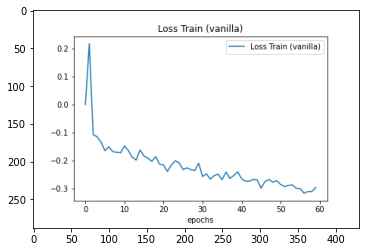

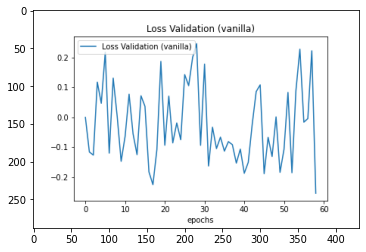

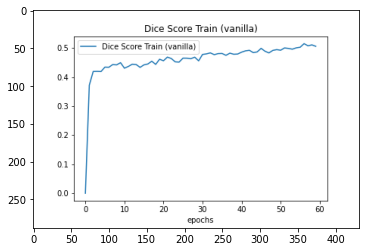

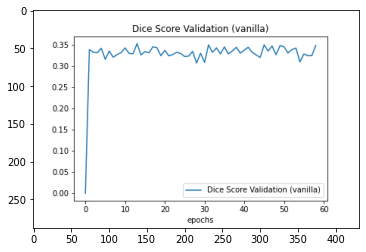

In [17]:
# Show dice score and loss for experiment 1
# utils.showLossAndDiceGraphs(networkType)
utils.showLossAndDiceGraphs(NetworkType.VANILLA)

In [0]:
# Run step 2 experiment
debug = True
networkType = NetworkType.WITH_AUGMENTATION
augmented = experiment(networkType, IMAGE_DIRECTORY, LABEL_DIRECTORY, maxEpochs, debug)

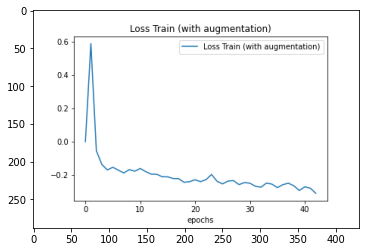

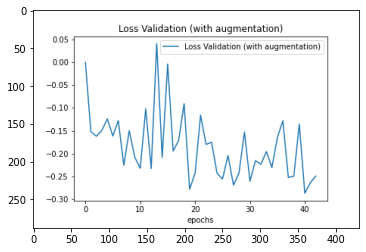

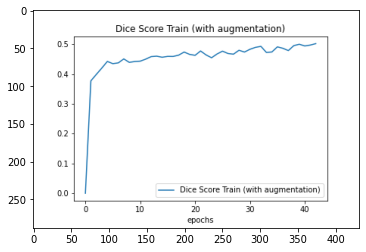

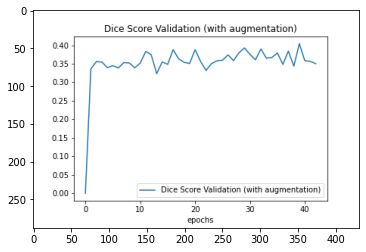

In [18]:
# Show dice score and loss for experiment 2
utils.showLossAndDiceGraphs(NetworkType.WITH_AUGMENTATION)

In [0]:
# Run step 3 experiment
debug = True
networkType = NetworkType.OPTIMISED
optimised = experiment(networkType, IMAGE_DIRECTORY, LABEL_DIRECTORY, maxEpochs, debug)

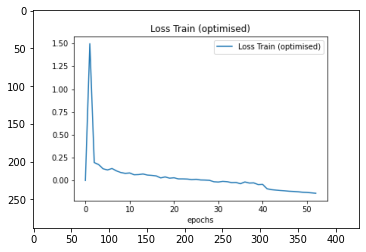

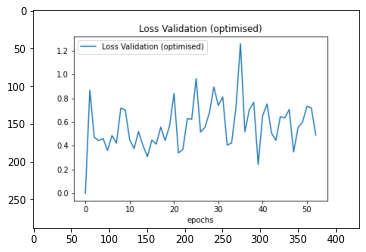

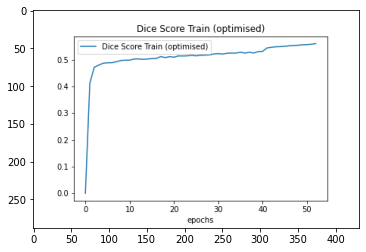

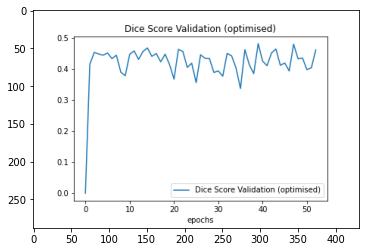

In [19]:
# Show dice score and loss for experiment 3
utils.showLossAndDiceGraphs(NetworkType.OPTIMISED)

In [0]:
# Run step 4 experiment
debug = True
networkType = NetworkType.WEIGHTED_LOSS
weighted = experiment(networkType, IMAGE_DIRECTORY, LABEL_DIRECTORY, maxEpochs, debug)

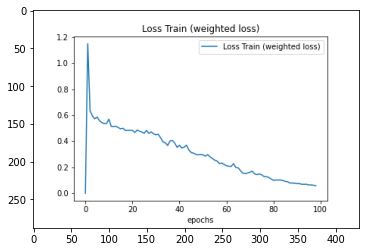

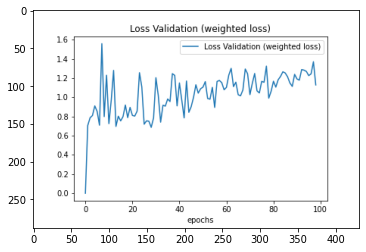

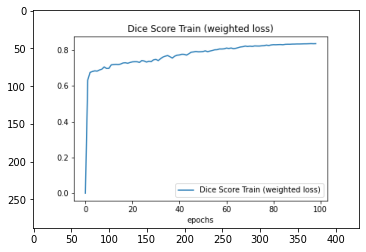

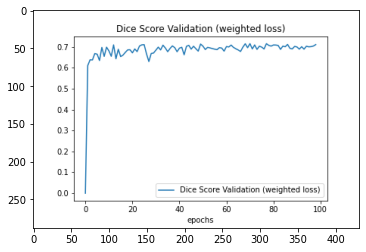

In [20]:
# Show dice score and loss for experiment 4
utils.showLossAndDiceGraphs(NetworkType.WEIGHTED_LOSS)

In [0]:
# Run step 5 experiment
debug = True
networkType = NetworkType.WITH_DROPOUT
dropout = experiment(networkType, IMAGE_DIRECTORY, LABEL_DIRECTORY, maxEpochs, debug)

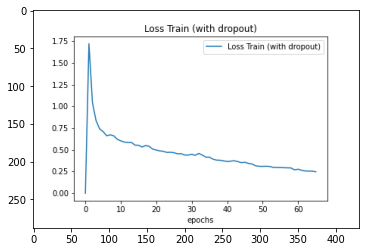

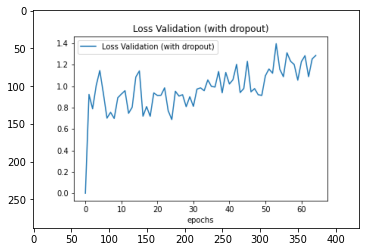

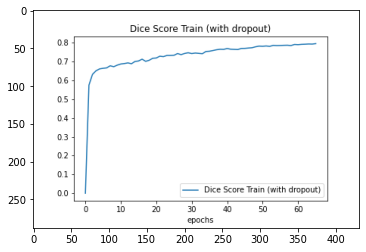

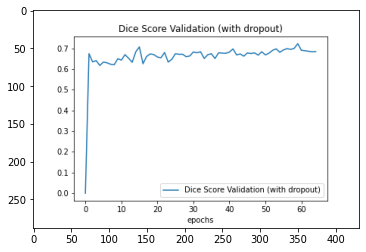

In [21]:
utils.showLossAndDiceGraphs(NetworkType.WITH_DROPOUT)

In [0]:
# Bonus round
debug = True
networkType = NetworkType.WITH_RESBLOCK
dropout = experiment(networkType, IMAGE_DIRECTORY, LABEL_DIRECTORY, maxEpochs, debug)

ResBlock DeepMedic scores (charts are mislabelled)


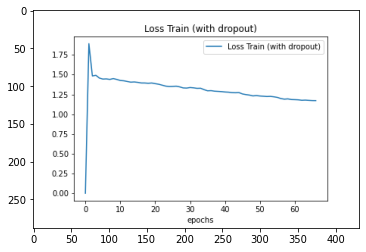

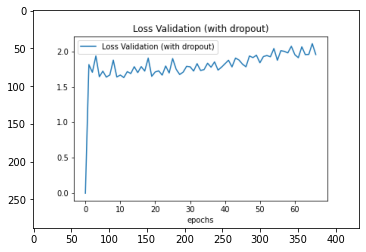

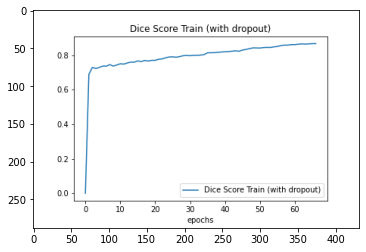

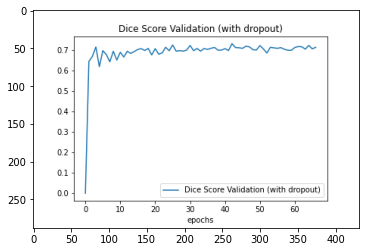

In [53]:
# The label of the chart is named incorrectly because I hadn't added the enum entry before I trained this
print("ResBlock DeepMedic scores (charts are mislabelled)")
utils.showLossAndDiceGraphs(NetworkType.WITH_RESBLOCK)

# Report
Note on Max Epochs: We're using 50 epochs for the first few experiments mainly because of limitations of colab. At 50 we usually reach the max training time allowed before we're locked out for the day.
In cases where more epochs are used, I made sure that when comparing the results, I compared them for the same point in time (epoch).

Note on Training data: Only 9GBs of training data (71 images for training and 17 for validation) were used due to issues with my Google Drive (not enough space)

# Experiment 1

## Parameters

* Network Type:  NetworkType.VANILLA
* Dropout:  (0.0, 0.0)
* Max Epochs:  50
* Traning set:  71
* Test set :  17
* Augmentation:  None
* Learning Rate:  0.0003
* Adaptive Learning Rate:  False
* Network scale:  3


## Pre-training

### Datasets and patches
We split the data 80/20 for training and validation respectively. 
Our training and validation data is then split into smaller patches as the whole image can't be loaded to the GPU. I used the size 57x57x57 as a starting point and experimented with smaller/larger patches in some of the following experiments. 
This size also allows us to load many more patches to the device than we would be able to even if we slightly increased the size.

For now patches are randomly selected.

### Normalisation
As advised by the author of DeepMedic, we normalise the data to zero-mean, unit-variance space [1]. 

## DeepMedic Network (Training)
The network consists of two convolutional pathways and a dense convolutional layer.
All convolutional layers except for the third of the dense layer use the following features:
```
nn.Conv3d(inChannels, outChannels, kernelSize, bias=False),
nn.BatchNorm3d(outChannels),
nn.PReLU(),
nn.Dropout(dropoutChance, inplace=True))
```

### First pathway (HighResPath)
Kernel size = 3

Input is a 25x25x25 image cropped from the original input
```
Layer 1: InChannels=1, outChannels=30, outsize=30 x 23 x 23 x 23
Layer 2: InChannels=30, outChannels=30, outsize=30 x 21 x 21 x 21
Layer 3: InChannels=30, outChannels=40, outsize=40 x 19 x 19 x 19
Layer 4: InChannels=40, outChannels=40, outsize=40 x 17 x 17 x 17
Layer 5: InChannels=40, outChannels=40, outsize=40 x 15 x 15 x 15
Layer 6: InChannels=40, outChannels=40, outsize=50 x 13 x 13 x 13
Layer 7: InChannels=40, outChannels=50, outsize=50 x 11 x 11 x 11
Layer 8: InChannels=50, outChannels=50, outsize=50 x 9 x 9 x 9
```

### Second pathway (LowResPath)
Kernel size = 3

Input is a 19x19x19 image downsampled from the original input
```
Layer 1: InChannels=1, outChannels=30, outsize=30 x 17 x 17 x 17
Layer 2: InChannels=30, outChannels=30, outsize=30 x 15 x 15 x 15
Layer 3: InChannels=30, outChannels=40, outsize=40 x 13 x 13 x 13
Layer 4: InChannels=40, outChannels=40, outsize=40 x 11 x 11 x 11
Layer 5: InChannels=40, outChannels=40, outsize=40 x 9 x 9 x 9
Layer 6: InChannels=40, outChannels=50, outsize=50 x 7 x 7 x 7
Layer 7: InChannels=50, outChannels=50, outsize=50 x 5 x 5 x 5
Layer 8: InChannels=50, outChannels=50, outsize=50 x 3 x 3 x 3
```

The output of the LowResPath is then upsampled to 50 x 9 x 9 x 9 and concatenated with the HighResPath to form a tensor of size 100 x 9 x 9 x 9.

### Dense Convolution layer
Kernel size = 1
Input is the output of the two pathways
```
Layer 1: InChannels=100, outChannels=150, outsize=100 x 9 x 9 x 9
Layer 2: InChannels=150, outChannels=150, outsize=150 x 9 x 9 x 9
Layer 3: InChannels=150, outChannels=3, outsize=3 x 9 x 9 x 9
```

## Training
As mentioned above, the total epochs are set to 50. We pass the images through the network in patches and then calculate the loss by adding pytorch's CrossEntropyLoss to the negative dice loss[2]. The dice loss is calculated by one hot encoding the label and softmaxing the network's output before using the standard formula.
We then append the current loss to a list containing all the losses so far so that that we can plot the mean.

## Results
As expected, without any augmentations or special weights added to our loss function and given the difficulty of finding small tumours, the dice score of our network is not very good. The dice score ends up being just ~0.45 for training and ~.40 for validation. The biggest issue here is the segmentation of tumours as the score for the other two classes is fairly high. This could also be attributed to class inbalance in our patch and label pairs.

It is worth mentioning that even if we stopped training at 50 epochs, the model still is still improving (loss has yet to plateau) so perhaps given enough time this could produce better results.

In [0]:
utils.showLossAndDiceGraphs(NetworkType.VANILLA)

# Experiment 2

## Parameters
* Network Type:  NetworkType.WITH_AUGMENTATION
* Dropout:  (0.0, 0.0)
* Max Epochs:  50
* Traning set:  71
* Test set :  17
* Augmentation:  ((0, 0.3), True, 1.5)
* Learning Rate:  0.0003
* Adaptive Learning Rate:  False
* Network scale:  3

## Augmentation
Here we used noise, contrast and gaussian blur as augmentation techniques. These techniques help create more diverse data by applying unseen effects to our images. This is important in our case since we have limited data.

## Augmentation Parameter explanation
Augmentation Parameters: ((0, 0.3), True, 1.5)

First element: Noise level between 0 and 0.3

Second element: Whether to use contrast or not. The contrast is added "automatically".

Third element: Gaussian blur multiplier 1.5

## Choice of augmentation parameters
After experimenting with various values and visualisating them, I concluded that the values shown above were the ones that produced the most reasonable results (i.e. images weren't complete noise or just a blur)

## Randomly occuring augmentations
To ensure that not all three augmentations happen every time, I added a threshold/acceptance percentage which is compared against a randomly generated number. If the number is greater than the threshold, then the augmentations take place.

## Results
The gap between training and validation was slightly larger in terms of the dice score (~0.5 for training and ~0.35 for validation).
In terms of the loss, the validation loss was much more stable in comparison to the non-augmentation one. This shows that the network is indeed more capable of handling unseen data.
Comparing this to the previous version of the model (without augmentation), there has been some performance boost as the dice scores at epoch 40 were ~0.45 for training and ~0.33 for validation

In [0]:
utils.showLossAndDiceGraphs(NetworkType.WITH_AUGMENTATION)

# Experiment 3

## Parameters

* Network Type:  NetworkType.OPTIMISED
* Dropout:  (0.0, 0.0)
* Max Epochs:  50
* Traning set:  71
* Test set :  17
* Augmentation:  ((0, 0.3), True, 1.5)
* Starting Learning Rate:  0.003
* Adaptive Learning Rate:  True
* Network scale:  3

## Learning Rate
After various experiments I concluded that starting with a learning rate of 0.003 yielded the best results.

Initially I employed the use of an adaptive learning rate which reduce the learning rate by a factor of 10 every 20 epochs. This number of epochs was chosen due to the limited number of epochs we are training for. 

As I will mention again in step 4, this was changed to a scheduler, which reduces the learning rate by half if there has been no improvement in the validation score in the last 10 epochs.

## Augmentation
In order to ensure even further randomness in the augmentation of data, I've added a random chance for each of the augmentations to occur individually instead of one for all. 
After some testing (and rough estimations), I concluded that giving each augmentation a 50% chance to occur yielded the best results for this step.

## Patching
At this point I decided to stop using random patches and selected patches that had a specific level of intensity. Even though this does not fix class inbalance, it at least ensures we get less patches that are just background.

## Weighting the losses
I experimented with weighting the two losses using a different multiplier for each. Given that I couldn't notice any difference in the long run nor could I find any relevant literature on how to decide said weights, I decided to not use this in the end.
```
totalLoss = crossEntropyLoss * alpha + diceLoss * beta
```

## Results
Here we can finally see that the dice score is increasing a bit. The training dice score is around ~0.55 and the validation dice score is around ~0.45.
The biggest factor for this is probably the patch intensity filter as it helps the network train faster by filtering out patch batches that only contained background.

In [0]:
utils.showLossAndDiceGraphs(NetworkType.OPTIMISED)

# Experiment 4

## Parameters
* Network Type:  NetworkType.WEIGHTED_LOSS
* Dropout:  (0.0, 0.0)
* Max Epochs:  100 (We increase this a bit here since the pipeline is a bit more complete)
* Traning set:  71
* Test set :  17
* Augmentation:  ((0, 0.3), True, 1.5)
* Starting Learning Rate:  0.003
* Adaptive Learning Rate:  True
* Network scale:  3

## Of Dice and Mean
Initially I assumed that the reason my dice score was so low was mainly because of class balance and lack of proper "precautions" taken against said inbalance. Even though I could generate some sort of decent segmentations, I couldn't get my dice score to increase significantly.

After a lot of time and trying a lot of different things, I realised that the way I was using dice to score my network was incorrect. My understanding was that for each iteration, I had to get the average of the dice coefficient (between the 3 classes). As soon as I fixed this bug, I could see that my dice score was more representative to the segmentations I was visualising.

Due to this, I will split this part of the report in to two parts, one with all my attempts using the incorrect dice score and one with the correct one. 

Furthermore, it is also worth noting that each of these tests took about a bit more than a day to run mainly because I reached colab's maximum allowance and had to continue training the next day.

## Wrong Dice Score

### Test 0
Unweighted dice with cross entropy weights [0.5, 2, 3]
converged at 40 epochs at 52%.
This produced a lot of misclassifications and more things being counted as liver instead of background. 

### Test 1
At this point I decided to improve my patching and force it to include more labels that contain a tumour. Therefore, from this point forward, the class bias filter is being used when patching.
Furthermore, I changed the weights of the CrossEntropyLoss to [1, 1, 3] and added weights to the dice function. 

A total of 4 weights were experimented with as shown below: 
```
V = sum of voxels in class
N = number of samples
L = number of labels
Weight1 = 1 / V
Weight2 = 1 / (V * V)
Weight3 = 1 / (v * V) and summing the weight for each class to 1
Weight4 = N / (L * V) [6]
```
Using these weights and the class bias patch filter, misclassification of the background dropped a bit. At the samae time, the network now started predicting tumours much more often than it should.

Unfortunately, I didn't save any of the results for this one.

### Test 2
Here I decided to move away from the dice loss suggested by the nnU-Net paper. Instead, I now experimented with the GDL loss as proposed by Carol H. Sudre et al [5].

#### Test 2.1
weights = [1.0, 1.0, 3.0] with GDL
Achieved score of 62% train at about 95 epochs 


#### Test 2.2 
Cross entropy weights = [1.0, 1.0, 2.0] with GDL
Converged at 87 epochs at 62% dice 


## Correct Dice Score

### Test 3
Weighted Cross Entropy [1, 2, 3] with unweighted dice (as proposed in the nnU-net paper)

### Test 4
Weighted Cross Entropy [1, 1, 3] with unweighted dice (as proposed in the nnU-net paper)

### Test 5
Weighted Cross Entropy [1, 2, 3] with Generalised weighted dice

### Test 6
Weighted Cross Entropy [1, 1, 3] with Generalised weighted dice

### Test 7
Unweighted Cross Entropy with Generalised weighted dice

## Final Choice
Unweighted Cross Entropy with Generalised Dice (test 7)

While all of these performed in almost similarly, I chose Test 6 as the final solution produced slightly better results and reached the top score faster than the rest. While the training could have lasted longer, at 100 epochs this was already taking about a day to run and given colab restrictions I couldn't really let it train longer.

It would have been worthwhile to explore using histogram normalisation to further enchance the detail on smaller tumours but given the time restrictions mainly due to the time spent trying out different loss functions, I was not able to implement this.


# Results
A lot of time was spent on this part but the results were fairly satisfying, reaching a dice score of about ~0.8 for training and ~0.7 for validation is a pretty big upgrade compared to the previous parts. It should be noted though that there is a small issue of the liver being classified more often than it should.



In [0]:
utils.showLossAndDiceGraphs(NetworkType.WEIGHTED_LOSS)

# Experiment 5

## Parameters
* Network Type:  NetworkType.WITH_DROPOUT
* Dropout:  (0.02, 0.5)
* Max Epochs:  100 (We increase this a bit here since the pipeline is a bit more complete)
* Traning set:  71
* Test set :  17
* Augmentation:  ((0, 0.3), True, 1.5)
* Starting Learning Rate:  0.003
* Adaptive Learning Rate:  True
* Network scale:  3

Due to the above issue I was not able to optimise the dropout parameters in regard to uncertainty. Instead I optimised them according to the dice score. 

## Dense layer dropout only
Here I tried using the "standard" value used in most convolutional networks which is p=0.5.

## Pathway and dense layer dropout
Here I added dropout layers after each pathway layer in addition to the ones on the dense layers. This didn't result in much difference over the dense layer dropout only version but I kept this version as it should provide more regularisation in theory. The dropout probability chosen for this is p=0.02 (as suggested by DeepMedic's author [1]) for the convolutional layer and p=0.5 for the dense layers.

## Results
Again we see some satisfying results for our model. The training dice score is ~0.80 and the validation score is ~0.69. Given that the loss is still improving, further training would have probably yielded in even better results.

When comparing this version to the previous one (at epoch 60), we see two models are almost identical in terms of score. Perhaps with more training this could have benefitted from the use of dropout layers for regularisation.


## Uncertainty estimation
Here I run into some major issues with colab. I am not sure why but I couldn't run the uncertainty loop consistently (sometimes it complained about memory issues and some times it didn't). Due to this, I was not able to refine it and the current implementation seems to have a bug I can't figure out.
Nevertheless I will attempt to explain the logic behind my uncertainty calculation to be best of my ability.

The main idea behind the **plotUncertainty()** function is to:
1.   Enable dropout during validation
2.   Load an image
3.   Make n predictions (n=100 in our case). They should result in different values even if we are using the same image because dropout is enabled.
4.   Add these predictions to an array
5.   Calculate the loglikelihood as recommended by Yarin Gal et al [3]
6.   Calculate the mean of the samples
7.   Calculate the standard deviation of the samples along with some other metrics
8.   Repeat for all images in the dataset

We then plot these metrics as line charts as well as a bar chart of the mean values with yError being the standard deviation. From this we can see how differently the model predicts its output and the effect of dropout. 

Moreover, by playing around and tuning the dropout chances/percentage even more, we could get a better idea of how the model deals with uncertainty.

Areas where there is high uncertainty are likely to cause misclassifications in our model. The model will try to fill in with what it already knows and in cases of under-represented classes this might cause the model to simply predict that the area is just background.

High uncertainty can be avoided by training the model more and using more data. In our case I would expect high uncertainty as both our data is limited (half of the recommended) and training was limited (original paper recommends 250 epochs with subepochs as opposed to our 50-100 total epochs).


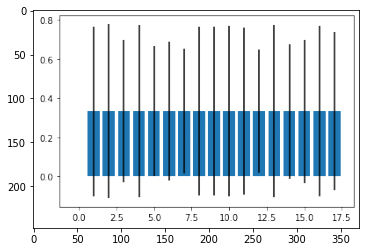

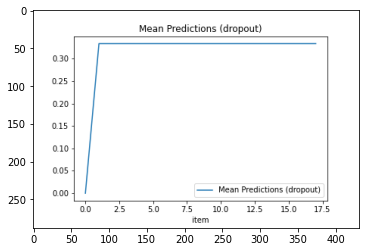

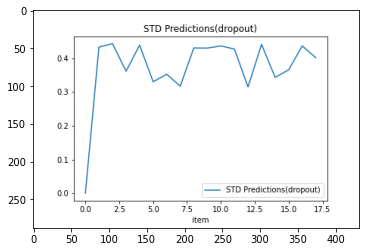

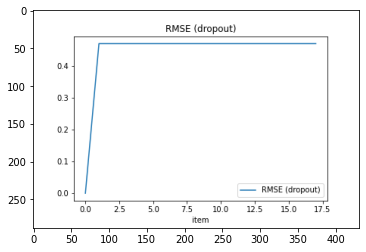

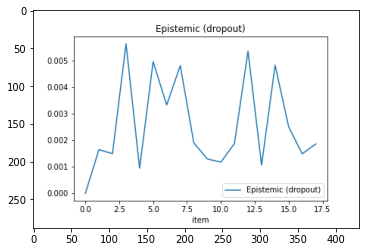

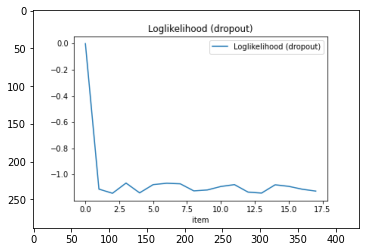

In [51]:
utils.showSavedImage("uncertainty")
utils.showSavedImage("Mean Predictions (dropout)")
utils.showSavedImage("STD Predictions(dropout)")
utils.showSavedImage("RMSE (dropout)")
utils.showSavedImage("Epistemic (dropout)")
utils.showSavedImage("Loglikelihood (dropout)")

-----DeepMedic using dropout-----
First row: Image Patch
Second row: Label
Third row: Prediction


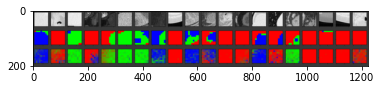

First row: Image Patch
Second row: Label
Third row: Prediction


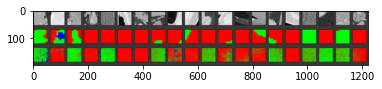

In [54]:
print("-----DeepMedic using dropout-----")
print("First row: Image Patch")
print("Second row: Label")
print("Third row: Prediction")
utils.showSavedImage("example (%s)" % NetworkType.WITH_DROPOUT.value)
print("First row: Image Patch")
print("Second row: Label")
print("Third row: Prediction")
utils.showSavedImage("example2 (%s)" % NetworkType.WITH_DROPOUT.value)

# Bonus round
At the end of this project, I tried to see if using the ResBlock DeepMedic model suggested by Po-Yu Kao et al (https://github.com/pykao/BraTS2018-tumor-segmentation)[4] could yield some better results for our problem.

## Results
Using this model I managed to boost the network's train score to ~0.83 Furthermore, not only did the score increase but it increased faster than with our standard DeepMedic model reaching its level in half the time. The validation score ended up being about the same at as the standard DeepMedic at ~0.70.
With the focus of the segmentation being on the middle part of the label, the segmentations shown below seem pretty accurate. 

ResBlock DeepMedic scores (charts are mislabelled)


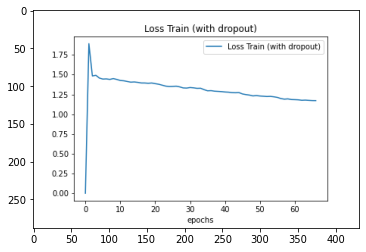

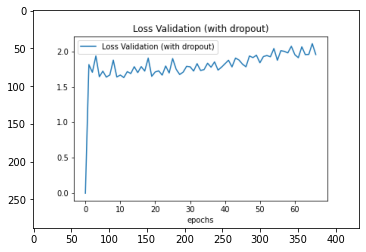

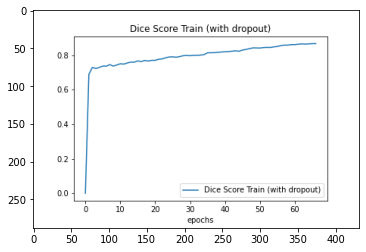

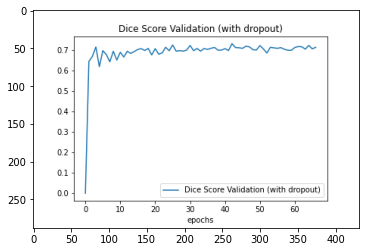

In [56]:
# Plots are mislabeled 
print("ResBlock DeepMedic scores (charts are mislabelled)")
utils.showLossAndDiceGraphs(NetworkType.WITH_RESBLOCK)

-----DeepMedic with ResBlock-----
First row: Image Patch
Second row: Label
Third row: Hot Encoded Label
Third row: Prediction
Third row: Class 0
Third row: Class 1
Third row: Class 2


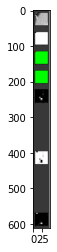

First row: Image Patch
Second row: Label
Third row: Prediction


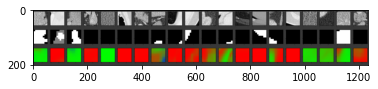

First row: Image Patch
Second row: Label
Third row: Prediction


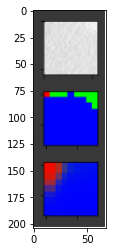

First row: Image Patch
Second row: Label
Third row: Prediction


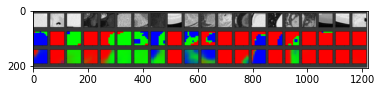

In [58]:
print("-----DeepMedic with ResBlock-----")
print("First row: Image Patch")
print("Second row: Label")
print("Third row: Hot Encoded Label")
print("Third row: Prediction")
print("Third row: Class 0")
print("Third row: Class 1")
print("Third row: Class 2")
utils.showSavedImage("example (%s)" % NetworkType.WITH_RESBLOCK.value)
print("First row: Image Patch")
print("Second row: Label")
print("Third row: Prediction")
utils.showSavedImage("example2 (%s)" % NetworkType.WITH_RESBLOCK.value)
print("First row: Image Patch")
print("Second row: Label")
print("Third row: Prediction")
utils.showSavedImage("example3 (%s)" % NetworkType.WITH_RESBLOCK.value)
print("First row: Image Patch")
print("Second row: Label")
print("Third row: Prediction")
utils.showSavedImage("example4 (%s)" % NetworkType.WITH_RESBLOCK.value)

# Conclusions for the individual part
While many different techniques were attempted the final results were not the best. Even though we achieved a final validation dice score of ~0.7, our segmentations weren't the best in all cases.

Furthermore, actually seeing the segmentations was a challenging task as the output of the network is of a different size than the input which means that reconstructing the image is a whole different problem.

In order to visualise the segmentations I tried the three following techniques:

1.   Downsample the image and pass it through the network
2.   Attempt to reconstruct the image through the output of the network (patch by patch)
3.   Simply look at the output of the network and compare it to the label

Regarding (1): The reduced quality of the image made the output in terms of visualisation.

Regarding (2): This proved to be very difficult and I did not have time to finish it.

Regarding (3): This is the technique I used mostly. I simply observed what was going on during training but even with this it was hard to tell how well the model was performing as the output images were very small.

Moreover, if time would allow, it would be interesting to see how the first experiments (lack of weighted losses, no augmentation, etc) would perform with the other improvements made to the model and pre-processing.

Overall, this has been a very challenging project and I have learned a lot from it. Perhaps it would be worth exploring different loss functions but I was unsure if this was within the projects scope.
The only negative aspect of this project was the limitations of Google Colab as it often meant waiting for at least a day before I could try different things.




-----DeepMedic with ResBlock-----


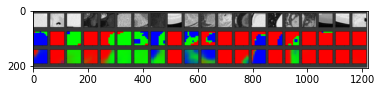

In [59]:
print("-----DeepMedic with ResBlock-----")
utils.showSavedImage("example4 (%s)" % NetworkType.WITH_RESBLOCK.value)

# Group Part
The ensemble of all 4 networks


# Meet the team
Below are the models of each student



# DeepMedic

In [0]:
class VDeepMedicNetwork(nn.Module):
    def __init__(self, c=1, n1=30, n2=40, n3=50, m=150, up=True):
        super(VDeepMedicNetwork, self).__init__()
        #n1, n2, n3 = 30, 40, 50
        # need 29 inputs
        self.scaleFactor = 3
        self.cropDiff = ((self.scaleFactor - 1) * 16) // 2

        n = 2*n3
        self.branch1 = nn.Sequential(
                conv3x3(c, n1),
                conv3x3(n1, n1),
                ResBlock(n1, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n2),
                ResBlock(n2, n3))

        self.branch2 = nn.Sequential(
                conv3x3(c, n1),
                conv3x3(n1, n1),
                conv3x3(n1, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n2),
                conv3x3(n2, n3),
                conv3x3(n3, n3))

        self.up3 = nn.Upsample(scale_factor=3,
                mode='trilinear', align_corners=False) if up else repeat

        self.fc = nn.Sequential(
                conv3x3(n, m, 1),
                conv3x3(m, m, 1),
                nn.Conv3d(m, 3, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1, x2 = self.getInputsForThePathways(x)
        x1 = self.branch1(x1)
        x2 = self.branch2(x2)
        x2 = self.up3(x2)
        x = torch.cat([x1, x2], 1)
        x = self.fc(x)
        return x

    def getInputsForThePathways(self, x):
        lowResInput = self.getLowResInput(x)
        highResInput = self.getHighResInput(x)
        return highResInput, lowResInput

    def getLowResInput(self, x):
        lowResShape = x.shape[2] // self.scaleFactor
        newShape = max(lowResShape, 19)
        return functional.interpolate(x, size=(19, 19, 19))
    
    def getHighResInput(self, x):
        return self.cropLayer(x, self.cropDiff)

    def cropLayer(self, x, border):
        border = border -4
        out_shape = [                    
            int(d) - 2 * int(border)
            for d in list(x.shape)[2:]]
        return x[:x.shape[0], :x.shape[1], :out_shape[0], :out_shape[1], :out_shape[2]]

class ResBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(ResBlock, self).__init__()
        self.inplanes = inplanes
        self.conv1 = nn.Conv3d(inplanes, planes, 3, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.conv2 = nn.Conv3d(planes, planes, 3, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        x = x[:, :, 2:-2, 2:-2, 2:-2]
        y[:, :self.inplanes] += x
        y = self.relu(y)
        return y

def conv3x3(inplanes, planes, ksize=3):
    return nn.Sequential(
            nn.Conv3d(inplanes, planes, ksize, bias=False),
            nn.BatchNorm3d(planes),
            nn.ReLU(inplace=True))

def repeat(x, n=3):
    # nc333
    b, c, h, w, t = x.shape
    x = x.unsqueeze(5).unsqueeze(4).unsqueeze(3)
    x = x.repeat(1, 1, 1, n, 1, n, 1, n)
    return x.view(b, c, n*h, n*w, n*t)


# V-Net

In [0]:
#V-net implementation

def passthrough(x, **kwargs):
    return x

def ELUCons(elu, nchan):
    if elu:
        return nn.ELU(inplace=True)
    else:
        return nn.PReLU(nchan)


class LUConv(nn.Module):
    def __init__(self, nchan, elu):
        super(LUConv, self).__init__()
        self.relu1 = ELUCons(elu, nchan)
        self.conv1 = nn.Conv3d(nchan, nchan, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(nchan)

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu1(self.conv1(x))
        return out


def _make_nConv(nchan, depth, elu):
    layers = []
    for _ in range(depth):
        layers.append(LUConv(nchan, elu))
    return nn.Sequential(*layers)


class InputTransition(nn.Module):
    def __init__(self, outChans, elu):
        super(InputTransition, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = ELUCons(elu, 16)

    def forward(self, x):
        # do we want a PRELU here as well?
        out = self.bn1(self.conv1(x))
        out = self.relu1(out)
        return out


class DownTransition(nn.Module):
    def __init__(self, inChans, nConvs, elu, dropout=False):
        super(DownTransition, self).__init__()
        outChans = 2*inChans
        self.down_conv = nn.Conv3d(inChans, outChans, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm3d(outChans)
        self.do1 = passthrough
        self.relu1 = ELUCons(elu, outChans)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x):
        down = self.relu1(self.bn1(self.down_conv(x)))
        down = self.relu1(self.down_conv(x))
        out = self.do1(down)
        out = self.ops(out)
        out = self.relu2(torch.add(out, down))
        return out


class UpTransition(nn.Module):
    def __init__(self, inChans, outChans, nConvs, elu, dropout=False):
        super(UpTransition, self).__init__()
        self.up_conv = nn.ConvTranspose3d(inChans, outChans // 2, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm3d(outChans // 2)
        self.do1 = passthrough
        self.do2 = nn.Dropout3d()
        self.relu1 = ELUCons(elu, outChans // 2)
        self.relu2 = ELUCons(elu, outChans)
        if dropout:
            self.do1 = nn.Dropout3d()
        self.ops = _make_nConv(outChans, nConvs, elu)

    def forward(self, x, skipx):
        out = self.do1(x)
        skipxdo = self.do2(skipx)
        out = self.relu1(self.bn1(self.up_conv(out)))
        #out = self.relu1(self.up_conv(out))
        xcat = torch.cat((out, skipxdo), 1)
        out = self.ops(xcat)
        out = self.relu2(torch.add(out, xcat))
        return out


class OutputTransition(nn.Module):
    def __init__(self, inChans, elu, nll):
        super(OutputTransition, self).__init__()
        self.conv1 = nn.Conv3d(inChans, 3, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm3d(3)
        self.conv2 = nn.Conv3d(3, 3, kernel_size=1)
        self.relu1 = ELUCons(elu, 3)
        if nll:
            self.softmax = F.log_softmax
        else:
            self.softmax = F.softmax

    def forward(self, x):
        # convolve 32 down to 3 channels
        out = self.relu1(self.bn1(self.conv1(x)))
        #out = self.relu1(self.conv1(x))
        out = self.conv2(out)

        # make channels the last axis
        #out = out.permute(0, 2, 3, 4, 1).contiguous()
        # flatten
        #out = out.view(out.numel() // 2, 2)
        out = self.softmax(out)
        # treat channel 0 as the predicted output
        return out


class VNet(nn.Module):
    # the number of convolutions in each layer corresponds
    # to what is in the actual prototxt, not the intent
    def __init__(self, elu=True, nll=False):
        super(VNet, self).__init__()
        self.in_tr = InputTransition(16, elu)
        self.down_tr32 = DownTransition(16, 1, elu)
        self.down_tr64 = DownTransition(32, 2, elu)
        self.down_tr128 = DownTransition(64, 3, elu, dropout=True)
        self.down_tr256 = DownTransition(128, 2, elu, dropout=True)
        self.up_tr256 = UpTransition(256, 256, 2, elu, dropout=True)
        self.up_tr128 = UpTransition(256, 128, 2, elu, dropout=True)
        self.up_tr64 = UpTransition(128, 64, 1, elu)
        self.up_tr32 = UpTransition(64, 32, 1, elu)
        self.out_tr = OutputTransition(32, elu, nll)

    # The network topology as described in the diagram
    # in the VNet paper

    def forward(self, x):
        out16 = self.in_tr(x)
        out32 = self.down_tr32(out16)
        out64 = self.down_tr64(out32)
        out128 = self.down_tr128(out64)
        out256 = self.down_tr256(out128)
        out = self.up_tr256(out256, out128)
        out = self.up_tr128(out, out64)
        out = self.up_tr64(out, out32)
        out = self.up_tr32(out, out16)
        out = self.out_tr(out)
        return out



# HighResNet

In [0]:
class HighResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation):
        super(HighResBlock, self).__init__()
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 3, stride=1, padding=dilation, dilation=dilation)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, stride=1, padding=dilation, dilation=dilation)

        self.skip = nn.Conv3d(in_channels, out_channels, 1, stride = 1)

    def forward(self, x):
        skip = self.skip(x)

        x = self.bn1(x)
        x = self.activation(x)
        x = self.conv1(x)

        x = self.bn2(x)
        x = self.activation(x)
        x = self.conv2(x)

        x = x + skip

        return x

class HighRes3DNet(nn.Module):
    def __init__(self, block, bnn = False, T = 5):
        super(HighRes3DNet, self).__init__()
        self.bnn = bnn
        self.T = T
        self.block = block
        self.in_channels = 1
        self.layer_1 = self._make_layer(16, 3, 1)
        self.layer_2 = self._make_layer(32, 3, 2)
        self.layer_3 = self._make_layer(64, 3, 4)
        
        self.layer_c = nn.Conv3d(64, 3, 1, stride=1)
        if self.bnn:
            self.logvar = self.block(64, 3, 1)
            
        self.classify = nn.Softmax(dim = 1)

    def _make_layer(self, out_channels, num_blocks, dilation):
        layers = []
        
        for i in np.arange(num_blocks -1):
            layers.append(self.block(self.in_channels, out_channels, dilation))
            self.in_channels = out_channels 
        
        layers.append(self.block(out_channels, out_channels, dilation))
        
        return nn.Sequential(*layers)

    def forward(self, x, return_logvar = False):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        c = self.layer_c(x)

        if self.bnn:
            logvar = self.logvar(x)
            e = torch.normal(0, 1, [logvar.shape[0], self.T, *logvar.shape[1:]]).to(device)
            logvar = logvar.unsqueeze(1)
            
            c = c.unsqueeze(1)
            rep = [1]*len(c.shape)
            rep[1] = T
            c = c.repeat(*rep)
            if self.training:
                c = c + e * torch.exp(logvar)
            c = c.permute(0, 2, 1, 3, 4, 5)
        
        c = self.classify(c)
        if self.bnn and return_logvar:
            return c, logvar
        return c

# U-Net

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# applying 3D convolution followed by batch normalisation, follwed by ReLU
def conv_block(in_chan, out_chan, stride=1):
    return nn.Sequential(
        nn.Conv3d(in_chan, out_chan, kernel_size=3, padding=1, stride=stride),
        nn.BatchNorm3d(out_chan),
        nn.ReLU(inplace=True)
    )
# Applying double convolutional layer
def conv_stage(in_chan, out_chan):
    return nn.Sequential(
        conv_block(in_chan, out_chan),
        conv_block(out_chan, out_chan),
    )

# Building 3D unet model double convolutional layer
class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.enc1 = conv_stage(1, 16)
    self.enc2 = conv_stage(16, 32)
    self.enc3 = conv_stage(32, 64)
    self.enc4 = conv_stage(64, 128)
    self.enc5 = conv_stage(128, 128)
    self.pool = nn.MaxPool3d(2, 2)

    self.dec4 = conv_stage(256, 64)
    self.dec3 = conv_stage(128, 32)
    self.dec2 = conv_stage(64, 16)
    self.dec1 = conv_stage(32, 16)
    self.conv_out = nn.Conv3d(16, 3, 1)

  def forward(self, x):
    # encoder
    enc1 = self.enc1(x)
    enc2 = self.enc2(self.pool(enc1))
    enc3 = self.enc3(self.pool(enc2))
    enc4 = self.enc4(self.pool(enc3))
    enc5 = self.enc5(self.pool(enc4))
        
    # decoder
    dec4 = self.dec4(torch.cat((enc4, F.interpolate(enc5, enc4.size()[2:],  mode='trilinear', align_corners=True)), 1))
    dec3 = self.dec3(torch.cat((enc3, F.interpolate(dec4, enc3.size()[2:],  mode='trilinear', align_corners=True)), 1))
    dec2 = self.dec2(torch.cat((enc2, F.interpolate(dec3, enc2.size()[2:],  mode='trilinear', align_corners=True)), 1))
    dec1 = self.dec1(torch.cat((enc1, F.interpolate(dec2, enc1.size()[2:],  mode='trilinear', align_corners=True)), 1))
    out = self.conv_out(dec1)

    # using softmax instaed of sigmoid because it is a multiclass, classification task
    out = torch.nn.Softmax(dim=1)(out)
    return out

# Load the models

In [0]:
# Function to load the models
# Unet
# Loading an already saved model
def loadModel(path, modelClass, fileName, parameterName):
    path = "%s/%s.pt" % (path, fileName)
    model = modelClass
    model.to(device)

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint[parameterName])

    return model 

def getModels():
    unet = loadModel(SAVE_DIRECTORY, UNet(), "model_unet", 'state_dict')
    unet.train()

    # Vnet
    # Loading saved unet model
    vnet = loadModel(SAVE_DIRECTORY , VNet(elu=False), "model_vnet", "model_state_dict")
    vnet.train()


    # HighResNet
    highResNet = HighRes3DNet(HighResBlock)
    highResNet.load_state_dict(torch.load(SAVE_DIRECTORY +'/model_highresnet'))
    highResNet = highResNet.to(device)

    # DeepMedic
    deepMedic = loadModel(SAVE_DIRECTORY, VDeepMedicNetwork(), "model_resblock", "model_state_dict")
    deepMedic.train()
    
    return unet, vnet, highResNet, deepMedic


# Make a prediction for each model
Here we generate a prediction for each model. Then in order to ensemble it we either simply average the prediction of each model or apply a weight to each prediction depending on their dice score.

In [0]:
def getPredictions(unet, vnet, highResNet, deepMedic, specificSample):

    # load an image and a label
    data, label = getDataAndLabel(specificSample)

    # loading the model and predicting on them
    outputUnet = unet(data)
    outputHighResNet = highResNet(data)
    outputVnet = vnet(data)

    # DeepMedic expects input divisible by three
    outputDeepMedic = deepMedic(data[:, :, :57, :57, :57])
    outputDeepMedic = functional.softmax(outputDeepMedic, dim=1)

    # Crop the outputs of Vnet, Unet and HighResNet to match the DeepMedic so that the comparison makes sense
    cropStart = 24
    cropEnd = 33
    outputUnet = outputUnet[:,:,cropStart:cropEnd, cropStart:cropEnd, cropStart:cropEnd]
    outputHighResNet = outputHighResNet[:,:,cropStart:cropEnd, cropStart:cropEnd, cropStart:cropEnd]
    outputVnet = outputVnet[:,:,cropStart:cropEnd, cropStart:cropEnd, cropStart:cropEnd]

    return data, label, outputUnet, outputVnet, outputHighResNet, outputDeepMedic

def getDataAndLabel(specificSample):
    sampleIndex = getSampleIndex(specificSample)
    return getSample(sampleIndex)

def getSampleIndex(specificSample):
    if specificSample is not None:
        return specificSample
    fileNames = listdir(IMAGE_DIRECTORY)
    totalFiles = len(imageNames)
    return random.randint(0, totalFiles)

def getSample(sample):
    # Retrieve image
    print("loading image %s" % sample)
    filepath = os.path.join(IMAGE_DIRECTORY, 'liver_{}.nii.gz'.format(sample))
    data = nib.load(filepath)
    data = np.array(data.get_fdata())
    filepath = os.path.join(LABEL_DIRECTORY, 'liver_{}.nii.gz'.format(sample))
    label = nib.load(filepath)
    label = np.array(label.get_fdata())

    # Patch image
    patching = ImagePatches((64,64,64), 3)
    data, label = patching(data, label)

    # Adjust image
    data = utils.getTensorFromNumpy(data).unsqueeze(0).permute(1, 0, 2, 3, 4).float()
    data = data.to(device)
    label = utils.getTensorFromNumpy(label).unsqueeze(0).permute(1, 0, 2, 3, 4).long()
    label = label.to(device)

    return data, label

def getEnsemblePrediction(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, weighted):
    # Get individual weights and scores
    outputUnet, outputVnet, outputHighResNet, outputDeepMedic, scores, weights = getWeightedPredictions(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, weighted)

    # Get the ensemble's score
    ensemblePrediction = (outputUnet + outputVnet + outputHighResNet + outputDeepMedic)
    if not weighted[0]:
        ensemblePrediction  = ensemblePrediction / 4
    diceCoefficient = DiceCoefficient(False)
    
    cropStart = 24
    cropEnd = 33
    label = weighted[1][:, :, cropStart:cropEnd, cropStart:cropEnd, cropStart:cropEnd]
    ensembleDiceScore, _ = diceCoefficient(ensemblePrediction, label)
    scores['Ensemble'] = ensembleDiceScore

    return ensemblePrediction, scores, weights

def getWeightedPredictions(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, weighted):
    # Unpack
    applyWeights = weighted[0]
    label = weighted[1]
    weights = {}
    scores = {}

    # Calculate dice scores
    diceUnet, diceVnet, diceHighResNet, diceDeepMedic = getDiceForEachNetwork(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, label)
    totalDice = (diceUnet +  diceVnet + diceHighResNet + diceDeepMedic).mean()

    # Calculate weights
    uWeight = diceUnet / totalDice if applyWeights else 1
    vWeight = diceVnet / totalDice if applyWeights else 1
    hWeight = diceHighResNet / totalDice if applyWeights else 1
    dWeight = diceDeepMedic / totalDice if applyWeights else 1

    # Save the weights 
    weights['UNet'] = uWeight
    weights['VNet'] = vWeight
    weights['HighResNet'] = hWeight
    weights['DeepMedic'] = dWeight

    # Save the scores
    scores['UNet'] =  diceUnet
    scores['VNet'] =  diceVnet
    scores['HighResNet'] =  diceHighResNet
    scores['DeepMedic'] =  diceDeepMedic

    return  outputUnet*uWeight, outputVnet*vWeight, outputHighResNet*hWeight, outputDeepMedic*dWeight, scores, weights

def getDiceForEachNetwork(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, label):
    cropStart = 24
    cropEnd = 33
    label = label[:, :, cropStart:cropEnd, cropStart:cropEnd, cropStart:cropEnd]
    diceCoefficient = DiceCoefficient(False)
    diceUnet, _ = diceCoefficient(outputUnet, label)
    diceVnet, _ = diceCoefficient(outputVnet, label)
    diceHighResNet, _ = diceCoefficient(outputHighResNet, label)
    diceDeepMedic, _ = diceCoefficient(outputDeepMedic, label)
    return diceUnet, diceVnet, diceHighResNet, diceDeepMedic


In [0]:
def showResults(data, label, outputUnet, outputVnet, outputHighResNet, outputDeepMedic, ensemblePrediction, scores, weights):
    figSize = (10,4)
    print('Original Image')
    utils.showImageBatch(data, figSize)

    print('Original Label')
    utils.showImageBatch(label, figSize)

    print('One hot encoded Label')
    hotLabel = getOneHotEncodedLabel(label[:, 0, :, :, :])
    utils.showImageBatch(hotLabel, figSize)

    print(getChartTitle("UNet", scores['UNet'].item(), weights['UNet']))
    utils.showImageBatch(outputUnet, figSize)

    print(getChartTitle("VNet", scores['VNet'].item(), weights['VNet']))
    utils.showImageBatch(outputVnet, figSize)

    print(getChartTitle("HighResNet", scores['HighResNet'].item(), weights['HighResNet']))
    utils.showImageBatch(outputHighResNet, figSize)

    print(getChartTitle("DeepMedic", scores['DeepMedic'].item(), weights['DeepMedic']))
    utils.showImageBatch(outputDeepMedic, figSize)

    print(getChartTitle("Ensemble", scores['Ensemble'].item()))
    utils.showImageBatch(ensemblePrediction, figSize)


def getChartTitle(itemName, score, weight=None):
    title = "%s: score=%s" % (itemName, score)
    if weight is not None and weight != 1:
        title += " weight=%s" % weight.item()
    return title


In [0]:
#Load models
unet, vnet, highResNet, deepMedic = getModels()

# Experiment 6

The ensemble works by loading an image (either random or a specific one) and making a prediction for each model. We then take each prediction and crop them to the center so that they match the smallest one (dimension wise). This is because DeepMedic returns a smaller output than the input provided. We could have instead downsampled/upsampled the data but it wouldn't have been a representative prediction. The reason a center crop is made is because DeepMedic's prediction focuses on the middle

We then add up the predictions and average them. As shown in the example below, this is not the best approach as two 2/4 models are completely wrong, the DeepMedic model is partly correct and only the Unet predicts the label correctly. This might just be an inconsistent error and the VNet and HighResNet might actually perform better on the average case.

For the example shown below, using the ensemble actually results in a worse prediction than simply using DeepMedic. This will not always be the case though as DeepMedic is not perfect and sometimes over-classifies things as tumours. Therefore, on the average case using the ensemble is a better choice. 

It is worth noting that the above statement is only valid if all the modules are trained appropriatly and sufficiently. If one of the models always underperforms, it will just bring the average score down.

DeepMedic score for this example: 0.92

Ensemble score for this example: 0.73

loading image 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:114: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Original Image


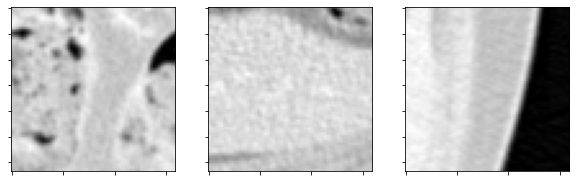

Original Label


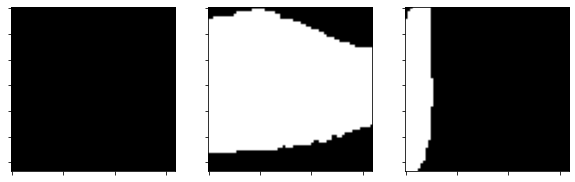

One hot encoded Label


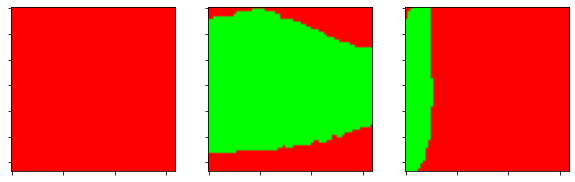

UNet: score=0.9999828338623047


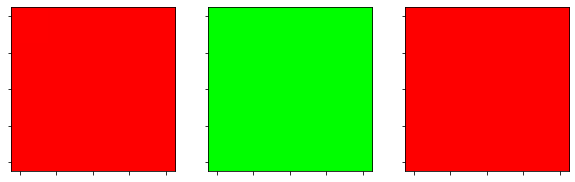

VNet: score=0.6666394472122192


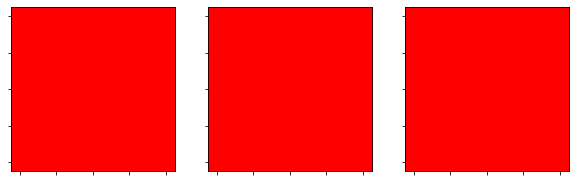

HighResNet: score=0.3278999924659729


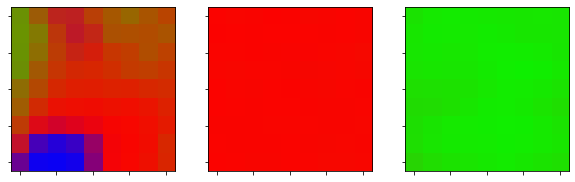

DeepMedic: score=0.922394335269928


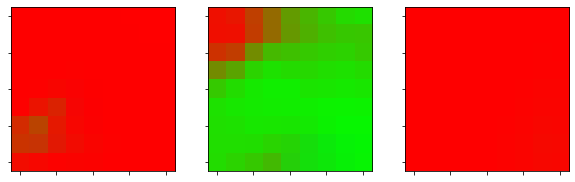

Ensemble: score=0.7292291522026062


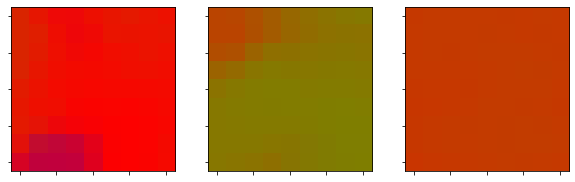

In [37]:
# Get the predictions
specificSample = 3
data, label, outputUnet, outputVnet, outputHighResNet, outputDeepMedic = getPredictions(unet, vnet, highResNet, deepMedic, specificSample)

# Ensemble the predictions
ensemblePrediction, scores, weights = getEnsemblePrediction(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, (False, label))

# Show the results
showResults(data, label, outputUnet, outputVnet, outputHighResNet, outputDeepMedic, ensemblePrediction, scores, weights)

#Experiment 7

We calculate the predictions the same way as we did for the previous step.

In order to calculate the weights, we calculate the score for each model and divide it by the total score (i.e. uNetDiceScore / totalScore).
This helps normalise the model's influence on the ensemble.

We then add up the weighted predictions. As shown in the example below, this is a vast improvement over the previous ensembling technique. Using weights we manage to boost the score by 10% for this case.

This is still a worse score than just using either UNet or DeepMedic on its own but again in the average case, this should yield better results as this might just be an inconsistent error by the VNet and HighResNet.

Furthermore, it should be noted that the weights should probably be calculated based on an average from the whole validation set instead of a per case method.
Care must be taken as if a small validation set is used, it could lead to weights that overfit our ensemble model

Other methods to ensemble the models are by using bagging, grid search or a linear solver..

One more method propopsed by is to add one of the models twice in the ensemble if we notice that it performs better than the rest in most cases.

DeepMedic score for this example: 0.92

Ensemble score for this example: 0.82

Original Image


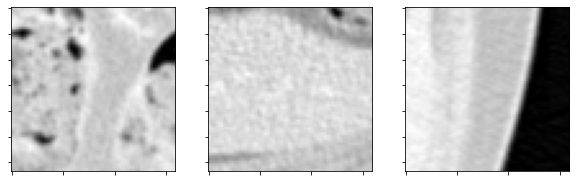

Original Label


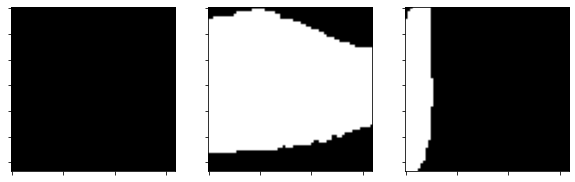

One hot encoded Label


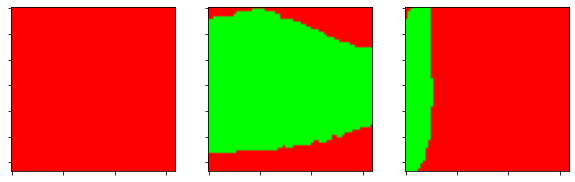

UNet: score=0.9999828338623047 weight=0.34282186627388


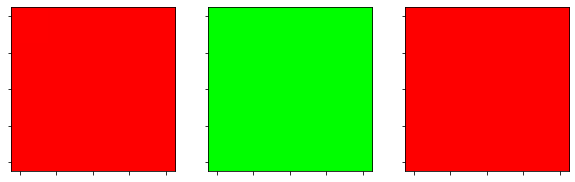

VNet: score=0.6666394472122192 weight=0.2285425066947937


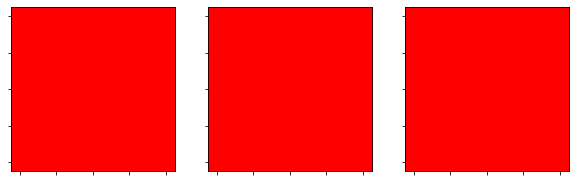

HighResNet: score=0.3278999924659729 weight=0.11241322010755539


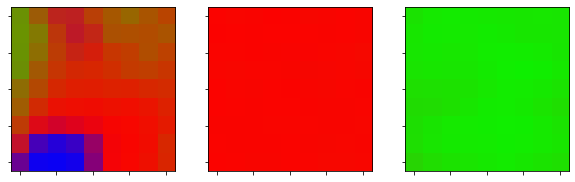

DeepMedic: score=0.922394335269928 weight=0.3162223994731903


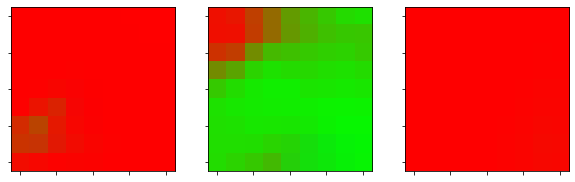

Ensemble: score=0.823713481426239


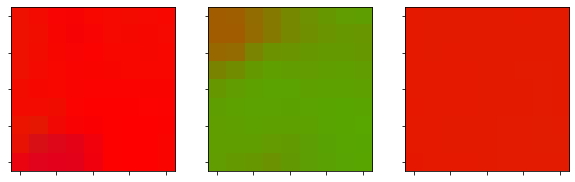

In [38]:
# Get the predictions
specificSample = 3
data, label, outputUnet, outputVnet, outputHighResNet, outputDeepMedic = getPredictions(unet, vnet, highResNet, deepMedic, specificSample)

# Ensemble the predictions
# ensemblePrediction, scores, _ = getEnsemblePrediction(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, (False, label))
ensemblePredictionWeighted, scores, weights = getEnsemblePrediction(outputUnet, outputVnet, outputHighResNet, outputDeepMedic, (True, label))

# Show the results
showResults(data, label, outputUnet, outputVnet, outputHighResNet, outputDeepMedic, ensemblePredictionWeighted, scores, weights)

# References
[1] Konstantinos Kamnitsas et al: "Efficient Multi-Scale 3D CNN with fully connected CRF for Accurate Brain Lesion Segmentation"

[2] Fabian Isensee et al: "nnU-Net: Self-adapting Framework for U-Net-Based Medical Image Segmentation"

[3] Yarin Gal et al: "Dropout as a Bayesian Approximation:Representing Model Uncertainty in Deep Learning"

[4] Po-Yu Kao et al: "Brain Tumor Segmentation and Tractographic Feature Extraction from Structural MR Images for Overall Survival Prediction"

[5] Carole H. Sudre et al: "Generalised Dice overlap as a deep learning lossfunction for highly unbalanced segmentations"

[6] Chen SHEN et al: "On the influence of Dice loss function in multi-class organsegmentation of abdominal CT using 3D fully convolutional networks"

[7] Xiang Li et al: "Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift"

[8] K. Kamnitas et al: "Ensembles of Multiple Models and Architectures for Robust Brain Tumour Segmentation"